<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales </p>
<p style="margin: 0; text-align:right;">MU Ingeniería Computacional y Matemática / Área de Inteligencia Artificial</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Laura Rivera Sanchez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>



# Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales 

El objetivo de este apartado es, a parte de la creación y entrenamiento de un red neuronal capaz de determinar la marca de calzado de una huella a partir de los datos disponibles. Se realizan diferentes experimentos con diferentes parámetros y procesos para analizar los resultados y poder concluir si éstas pueden dar un resultado satisfactorio.

Con este proyecto se quiere dar respuesta a las siguientes preguntas o hipótesis mediante los experimentos:
1.	¿Qué preprocesado de imágenes funciona mejor?
2.	¿Utilizar más epochs, resulta siempre en mejor resultado?
3.	¿Un mayor tamaño de las imágenes utilizadas, resulta en un mejor resultado?
4.	¿Cuál es el mínimo de muestras por marcas aceptable para el modelo?




In [76]:
#librerias necesarias:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import skimage
import cv2 as cv
import pickle

In [4]:
#En caso de utilizar google colab:
#from google.colab import drive
#drive.mount('/content/gdrive')

# Lectura y análisis de los conjuntos de datos






## Base de datos 2d FootWear con información de marca

Base de datos extraída de: https://iastate.figshare.com/articles/figure/2D_Footwear_outsole_impressions/11624073/1

https://www.sciencedirect.com/science/article/pii/S2352340920304029?via%3Dihub

In [ ]:
with ZipFile('data/2dFootwear/Part1.zip', 'r') as zipObj:
  zipObj.extractall('images')

with ZipFile('data/2dFootwear/Part2.zip', 'r') as zipObj:
  zipObj.extractall('images')



In [ ]:
with ZipFile('data/2dFootwear/Part3.zip', 'r') as zipObj:
  zipObj.extractall('images')

with ZipFile('data/2dFootwear/Part4.zip', 'r') as zipObj:
  zipObj.extractall('images')

with ZipFile('data/2dFootwear/Part5.zip', 'r') as zipObj:
  zipObj.extractall('images')

In [68]:
def unzipImages(folder='images'):
    with ZipFile('data/2dFootwear/Part1.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part2.zip', 'r') as zipObj:
      zipObj.extractall(folder)
    with ZipFile('data/2dFootwear/Part3.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part4.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part5.zip', 'r') as zipObj:
      zipObj.extractall(folder)

### Análisis de los datos 2d Footwear
(Explicar)

In [8]:
df = pd.read_csv('data/2dFootwear/Data-information.csv', delimiter=';')
df['Brand'] = df['Brand'].str.strip() #eliminar espacios en blanco

X_files = df['ID'].values.tolist()
brands = df['Brand'].values.tolist()

values_brand, counts_brand = np.unique(brands, return_counts=True)
print('Tag example:',X_files[0]) #nomenclatura 
print('Nº lines:',len(X_files)) #lineas en el csv
individuals, count_ind = np.unique(df['ID'].str[:3], return_counts=True)
print('Nº different people:',len(individuals)) #diferentes individuos de la muestra
num_classes = len(values_brand) #se guarda porque será necesario para crear el modelo
print('Nº of different brands: %d' %num_classes) #marcas diferentes
print(values_brand) #Listado de marcas únicas



Tag example: 001_01
Nº lines: 150
Nº different people: 28
Nº of different brands: 60
['Adidas' 'Airspeed' 'Airwalk' 'Aldo' 'American Eagle' 'Arizona' 'Asics'
 'BAGO' 'BASS' 'Birkenstock' 'Brooks' 'CalvinKlain' 'Champion' 'Clarks'
 'Columbus' 'Converse' 'Cooeli' 'Court classic' 'Dansko' 'Deer Stags'
 'Dockers' 'Ecco' 'Elcanto' 'Fadedglory' 'Feiyue' 'Fila' 'G.H.Bass&Co'
 'Guho' 'HeyBear' 'K-swiss' 'Keen' 'Landya' 'Namuhana' 'Newbalance' 'Nike'
 'Ninewest' 'None' 'OP' 'Ofem' 'Prospecs' 'Puma' 'Robin' 'Saucony'
 'Shoedy' 'Shoopen' 'Simply vera' 'Skechers' 'Soma' 'Sonoma' 'Sorel'
 'Sperry' 'Stone' 'Sugar' 'T2R' 'Teva' 'Truesoft' 'Under Amour' 'Vans'
 'Vibram' 'Yonex']


A continuación, el histograma con el número de muestras según género, en este caso hay 70 muestras de mujeres y 80 de hombres.

(array([71.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 79.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

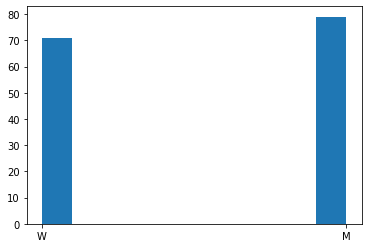

In [9]:
plt.hist(df['Gender'])

Por último, se muestran las cinco marcas que más aparecen en el conjunto de datos. \
Además se seleccionan esas marcas que aparecen minimo 5 veces en la muestra, para crear un subconjunto de datos que elimine las marcas con una única muestra y comprobar en los siguientes casos si influye en el resultado.


Brands with at least 5 samples: 7
Brands with only 1 register: 52


<AxesSubplot: xlabel='x'>

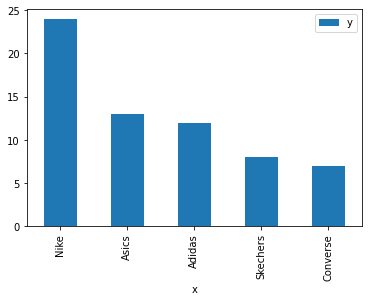

In [26]:

def filterMinSamples(data, minSamples, deleteNone=True):
    if deleteNone == True:
        data=data[data['x']!="None"] #eliminar marca = "None"
    dataone=data[data['y']<minSamples] #marcas con pocas muestras
    data=data[data['y']>=minSamples] #marcas con minimo "minSamples" muestras
    num_classes=len(data)
    print('Brands with at least '+str(minSamples)+' samples: %d' %num_classes) 
    print('Brands with only 1 register: %d' %len(dataone)) 
    return data, dataone

dfbrandall = pd.DataFrame({'x':values_brand, 'y':counts_brand}) 

dfbrand, dfbrandone = filterMinSamples(dfbrandall, 5)

num_classes=len(dfbrand)
dfbrand = dfbrand.sort_values('y', ascending = False) #ordenar descendientemente

# mostrar las 5 marcas que más aparecen en el conjunto de datos
dfbrand.head(5).plot('x', 'y', kind='bar') #mostrar gráfica



In [69]:
def crop_jpeg(crop_size, imgPath):
    dir_list = os.listdir("./"+imgPath)
    for f in dir_list:
        im = Image.open("./"+imgPath+"/"+f)
        h,w,c = im.shape
        im3 = im2.crop((crop_size,crop_size,h-(crop_size*2),w-(crop_size*2))) #Quitar marco medidor

def get_images_full_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result


def get_images_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im2=im.resize((400,912))
    im3 = im2.crop((40,40,320,872)) #Quitar marco medidor
    im3.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result

def get_images(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []
  for f in dir_list:  
    result.append(f)


  print('Nº files:',len(result))
  return result

In [22]:
# Get the list of all files in /images and convert to jpeg
#shoeFiles = get_images_to_jpeg("images") #la primera vez para convertir las imágenes
shoeFiles = get_images("images")

Nº files: 1500


### Visualización de imágenes

Se ha creado la función *plot_image* que permite la visualización de las imágenes de cualquiera de las dos bases de datos.

Parámetros:\
*imgPath*: carpeta donde estan las imágenes \
*fileNames*: array con los nombres de los ficheros a mostrar


In [23]:

import skimage
def plot_image(imgPath, fileNames):
  for i in range(len(fileNames)):
    filename = fileNames[i]
    img = skimage.io.imread(imgPath+filename)
   
    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)
  print(fileNames)
  plt.show()

def plot_image2(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)

    plt.show()
def plot_image_grey(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img, cmap='gray')

    plt.show()

A continuación, se muestra una imagen aleatória de cada uno de los 3 datasets del proyecto:

In [ ]:
plot_image("images/",random.choices(shoeFiles,k=1))

## División de los datos

Para la división de los datos se ha utilizado la funcióon train_test_split dos veces, primero para dividir entre el 80% de train y el 20% de test y después para extraer el equivalente al 10% para la validación. 

De esta manera se dispone de 70% train, 20% test y 10% validación.


Antes de dividir los datos de la base de datos 2d Footwear, se ha formateado la tabla ya que actualmente solo muestra la información de marca según el calzado del usuario, pero no contiene el nombre de la imagen, se ha creado la siguiente función para que el conjunto de datos contenga dos columnas (X:fichero, y:marca)

In [59]:
def filesWithBrand(shoeFiles):
  files = []
  brands = []
  for image in shoeFiles:
    files.append(image) #filename
    person = df[df['ID'].str[:6]==image[:6]]  #persona+contador de calzado
    brands.append(person['Brand'].iloc[0])

  return pd.DataFrame({'X':files, 'y':brands}) 

def filterBrands(data, one, deleteNone=True):
    #dfbrandone creado antes con las marcas que no cumplen.
    df_shoe_brand=data[~data['y'].isin(one['x'].to_numpy())]
    
    if deleteNone == True:
        df_shoe_brand=df_shoe_brand[df_shoe_brand['y']!="None"]
    
    
    df_shoe_brand['factor_brand'] = pd.Categorical(pd.factorize(df_shoe_brand['y'])[0].astype(np.float32))
    
    return df_shoe_brand

df_shoe_brand_all = filesWithBrand(shoeFiles) #contiene todas las muestras

#eliminar aquellas marcas que no aparecen mínimo en "minSample" muestras 
df_shoe_brand = filterBrands(df_shoe_brand_all,dfbrandone)
print(df_shoe_brand)
#número de marcas con 5 o más muestras:
print('Nº of brands: %d' %num_classes)

                     X         y factor_brand
3     009_08_R_05.jpeg     Asics          0.0
8     010_01_L_01.jpeg  Skechers          1.0
13    025_05_R_01.jpeg     Asics          0.0
15    020_03_R_03.jpeg    Sperry          2.0
17    011_03_L_04.jpeg    Adidas          3.0
...                ...       ...          ...
1490  020_02_L_01.jpeg  Skechers          1.0
1493  011_01_R_04.jpeg    Adidas          3.0
1494  026_07_L_03.jpeg   Saucony          6.0
1496  018_04_R_02.jpeg    Sperry          2.0
1499  025_03_L_04.jpeg      Nike          4.0

[770 rows x 3 columns]
Nº of brands: 7


In [28]:
def checkBalancedSample(train, test, val):
    checkTest = False
    checkVal = False
    
    #Comprobar si existen en train
    test_in = test.y.isin(train.y).astype(int)
    val_in=val.y.isin(train.y).astype(int)

    #Comprobar que existen todos (todo 1)  
    if all(x==1 for x in test_in):
        checkTest = True
    if all(x==1 for x in val_in):
        checkVal = True
    #Devuelve True si en test y val aparecen marcas que existen en train:
    if checkTest and checkVal:
        return True
    return False

In [29]:
from sklearn.model_selection import train_test_split
def  split_datafiles(df):
  X_train, X_test = train_test_split(df, test_size=0.2 , random_state=random.randint(0,32),shuffle=True)

  X_train, X_val = train_test_split(X_train, test_size=0.14, random_state=random.randint(0,32),shuffle=True) # 0.14 x 0.7 = 0.1
  return X_train,  X_test ,X_val

#Dividir conjunto de datos:
#shoes_train, shoes_test, shoes_val = split_datafiles(df)
shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)

while checkBalancedSample(shoes_train, shoes_test, shoes_val) == False:
    shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)
    

# Objetivo 1: Predicción de la marca de calzado utilizando redes neuronales convolucionales 

En este apartado, primero se utilizan diferentes clasificadores para comparar, posteriormente, su resultado con el de la red neuronal convolucional propuesta con diferentes valores en sus parámetros.

??
- Augmentación en los datos.
- Uso del modelo preentrenado RestNet.
- Uso de autokeras para determinar si encuentra mejor modelo que el propuesto.




## Extracción de características

La extracción de características es el proceso de recuperar los datos más importantes de los datos sin procesar. La extracción de características es encontrar el conjunto de parámetros que definen la forma de una imagen de manera precisa y única.

Para la extracción de características se utiliza la técnica Bag of Features, que extrae N características de las imágenes utilizando los descriptores SIFT (Scale Invariant Feature Transform).

Existen diferentes algoritmos de extracción de caraterísticas y para este proyecto se escoge utilizar SIFT ya que KAZE y ORB tienen cuenta las rotaciones y en este caso no sería necesario, ya que todas las muestras se toman con la misma metodologia.
 
Se hace uso de la librería OpenCV, de uso libre y con funcionalidades de visión por computador.


In [15]:
!pip install opencv-contrib-python==4.4.0.44 

In [ ]:
#extrae y calcula los descriptores SIFT para el conjunto de imágenes enviado
def extractSIFT(input_files):
    all_features_dict = {}
    feature_extractor = cv.SIFT.create()
    for i, fname in enumerate(input_files):
        rgb = cv.cvtColor(cv.imread("images/"+fname), cv2.COLOR_BGR2RGB)
        gray = cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)
        kp, desc = feature_extractor.detectAndCompute(gray, None)
        all_features_dict[fname] = desc
    return all_features_dict

In [ ]:
#Esta función extrae las características de cada categoria (marca)
#input: listado de categorias (marcas), listado de ficheros, marca de cada fichero
#output: lista ficheros, lista categorias, lista de características
def getFiles(cat_list, X_files, y_values):
  all_files = []
  all_files_labels = {}
  all_features = {}
  cat_indexes= []
  cat_files = []
  cat_features = []

  #values_train contiene el listado de categorias sin repeticiones 
  for cat, label in zip(cat_list, range(len(cat_list))):
      
      #primero buscar los indices en el listado de cada categoria (dentro bucle)
      cat_indexes = [i for i,x in enumerate(y_values) if x == cat]
      
      #como se saben las posiciones, se cogen esas imagenes de esa categoria:
      cat_files = [X_files.iloc[i] for i in cat_indexes]
      cat_features = extractSIFT(cat_files)
      all_files = all_files + cat_files
      all_features.update(cat_features)
      for i in cat_files:
          all_files_labels[i] = label
  return all_files, all_files_labels, all_features

Bag of features

https://www.researchgate.net/publication/260952140_A_Detailed_Review_of_Feature_Extraction_in_Image_Processing_Systems

https://www.sciencedirect.com/topics/engineering/feature-extraction

https://www.naun.org/main/NAUN/bio/bio-2.pdf

In [18]:


def getFilesBySubset(subset, tipo):
    #values_brand= np.unique(subset['y']) #listado marcas únicas que aparecen en subconjunto TRAIN

    if os.path.exists("saved/all_files_nonone_"+tipo+".pkl"):
        with open('saved/all_files_nonone_'+tipo+'.pkl', 'rb') as fp:
            all_files = pickle.load(fp)
        with open('saved/all_files_nonone_labels_'+tipo+'.pkl', 'rb') as fp:
            all_files_labels = pickle.load(fp)
        with open('saved/all_features_nonone_'+tipo+'.pkl', 'rb') as fp:
            all_features = pickle.load(fp)
        #all_files_train = np.loadtxt('saved/all_files_train.txt')
        #all_files_labels_train = np.loadtxt('saved/all_files_labels_train.txt')
        #all_features_train = np.loadtxt('saved/all_features_train.txt')
    else:
        all_files, all_files_labels, all_features=getFiles(values_brand,subset['X'],subset['y'])

    return all_files, all_files_labels, all_features


In [ ]:
values_brand= np.unique(df_shoe_brand['y']) #listado marcas únicas que aparecen en subconjunto TRAIN

all_files_train, all_files_labels_train, all_features_train=getFilesBySubset(shoes_train, "train")
#Este proceso tarda 40 minutos aproximadamente, por eso se guarda en un fichero para agilizar las pruebas

In [ ]:

if not os.path.exists("saved/all_files_nonone_train.pkl"):
    with open('saved/all_files_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_files_train, fp)
    with open('saved/all_files_labels_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_files_labels_train, fp)
    with open('saved/all_features_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_features_train, fp)
        

A continuación un ejemplo de la matriz de características y la impresión de la imagen con los puntos puntos de interés detectados.

In [ ]:
#guarda la primera imagen  con los puntos de interés
img = cv.imread("images/"+all_files_train[0])
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

features = cv2.SIFT_create()
keypoints = features.detect(gray, None)

img2=cv.drawKeypoints(gray,keypoints,0,(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('results/'+all_files_train[0], img2)



In [ ]:
#Se crea el Bag of Features con un diccionario de tamaño 75:
dictionarySize =75
if not os.path.exists("saved/bow_dict_nonone.pkl"):
    
    BOW = cv.BOWKMeansTrainer(dictionarySize)

    for feat in all_features_train:
        BOW.add(all_features_train[feat])
    dictionary = BOW.cluster()
else:
    with open('saved/bow_dict_nonone.pkl', 'rb') as fp:
        dictionary = pickle.load(fp)
print(dictionary.shape)
print(all_features_train[all_files_train[0]].shape) #subdivisión de train: shoes_train

In [ ]:
import pickle
if not os.path.exists("saved/bow_dict_nonone.pkl"):
    with open('saved/bow_dict_nonone.pkl', 'wb') as fp:
        pickle.dump(dictionary, fp)
        print('BOW dictionary saved successfully to file')
        
#Como se trata de un proceso que toma bastante tiempo, también se ha decidido guardar el resultado en un fichero para futuras ejecuciones

In [ ]:
def getFeatures(all_files, all_features, all_files_labels):
  X = np.empty((len(all_files),dictionarySize))
  y = np.empty((len(all_files),))
  all_features_BOW = {}

  count = 0
  for filename in all_files:
      desc_query = all_features[filename]
      matches = matcher.match(desc_query,dictionary)
      train_idxs = []
      for j in range(len(matches)):
        train_idxs.append(matches[j].trainIdx)
      hist, bin_edges = histogram(train_idxs, bins=range(dictionarySize+1))
      all_features_BOW[filename] = hist
      X[count,:] = hist
      y[count] = all_files_labels[filename]
      count = count + 1
  return X,y

In [ ]:
from numpy import histogram
import numpy as np

#Comentario: A continuación se normaliza el numero de caracteristicas para que todas tengan la misma cantidad,
#ya que con el proceso anterior (BOW) es muy probable que las imagenes tengan numero de caracteristicas diferentes.

matcher = cv.BFMatcher(normType=cv.NORM_L2)

X, y = getFeatures(all_files_train, all_features_train, all_files_labels_train)


### Support Vector Machines (SVM)

TODO: Descripción

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV

X_train, X_test_t, y_train, y_test_t = train_test_split(X, y, test_size=0.3, random_state=0)

# Set the parameters by cross-validation
kernels =  ["rbf", "linear", "poly", "sigmoid"]
Cs= [1, 2,3,4, 5, 10, 20]


#Se utiliza GridSearchCV para identificar la mejor configuración de entre los diferentes kernel con diferentes
#valores de C.
clf = GridSearchCV(estimator=svm.SVC(), param_grid=dict(C=Cs, kernel=kernels),n_jobs=-1)
clf.fit(X_train, y_train)

print('Mejor configuración kernel=%s, c= %s con un score de %s' %(clf.best_estimator_.kernel, clf.best_estimator_.C, clf.best_score_))

In [ ]:
#Ejecuto la configuración con mejor resultado kernel=rbf, c=20:

clf_train = svm.SVC(kernel='rbf', C=20).fit(X_train, y_train)
clf_train.score(X_test_t, y_test_t)

In [ ]:
all_files_test, all_files_labels_test, all_features_test=getFilesBySubset(shoes_test, "test")
X, y = getFeatures(all_files_test, all_features_test, all_files_labels_test)

clf_train.score(X,y)


In [ ]:
#Resultado de la predicción:
from sklearn.metrics import accuracy_score
print(accuracy_score(y, result))
#print(confusion_matrix(y,result))

In [ ]:
#print(shoes_test.iloc[3])
#print(prediction[3])

### KNeighborsClassifier

TODO: Descripción

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=num_classes)
model.fit(X_train, y_train)
model.score(X_test_t, y_test_t)


In [ ]:
#partición de test
model.score(X,y)

### DecisionTreeClassifier

Explicación
TODO: Descripción

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model.score(X_test_t, y_test_t)

In [ ]:
#partición de test
model.score(X,y)

## Resultados clasificadores






## Red neuronal de clasificación de imágenes por Marca

En este caso los datos ya estan etiquetados, por lo que se puede crear un modelo para que entrene según esa etiqueta. 


*Es necesario transformar las etiquetas de marcas a numérico para el correcto funcionamiento del modelo. Paso realizado en los primeros pasos*





In [118]:
#Se ha creado un generador para añadir la aumentación de las imágenes
import torchvision.io
import torch
from tensorflow.keras.utils import Sequence
import torchvision.transforms as T
from torchvision.transforms import Resize
from skimage.io import imread
from skimage.util import img_as_float,random_noise
from skimage.transform import rotate
from skimage.color import rgb2gray
import numpy as np
import random
import os
from skimage import io
from skimage import transform, util



#función que elimina las filas y columnas en blanco:
def crop_image(gray, pixel_value=220):
    #gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    crop_rows = gray[~np.all(gray > pixel_value, axis=1), :]
    cropped_image = crop_rows[:, ~np.all(crop_rows > pixel_value, axis=0)]
    return cropped_image

def create_variation(theImage,doFlip,doNoise,doRotate):
  image = img_as_float(theImage)
  if doFlip==True:
    image = np.fliplr(image)
  if doNoise==True:
    image = util.random_noise(image)
  if doRotate==True:
    image = transform.rotate(image, random.randint(-45, 45),mode='symmetric')
  return image

class DataGenerator2dFootwear(Sequence):
    # Constructor. Input parameters are:
    # * fileNames   : List of sample file names
    # * doRandomize : If True, the provided file names are shuffled after each training epoch
    #                 and each image can be left unchanged, flipped, corrupted with
    #                 noise or rotated. 8 possible combinations is chosen randomly with equal probability.
    #                 If False, file names are not shuffled and each image is provided unchanged.
    # * imgPath     : Path to the images 
    # * batchSize   : Number of sample images and ground truth items in each batch
    def __init__(self,data, df_shoe_brand,doRandomize=False,imgPath='images', doGray=True,doBin=True, doCrop = True,batchSize=10):
        # Store parameters
        self.imgPath=imgPath
        self.fileNames=data.copy()
        self.batchSize=batchSize
        self.doRandomize=doRandomize
        self.df_shoe_brand=df_shoe_brand
        self.doGray=doGray
        self.doBin=doBin
        self.doCrop=doCrop
        # Get number of files (to avoid computing them later)
        self.numImages=len(data)
        # Shuffle them if required
        self.on_epoch_end()

    # Shuffle data if required
    def on_epoch_end(self):
        if self.doRandomize:
            random.shuffle(self.fileNames)

    # Returns the number of total batches
    def __len__(self):
        return int(np.ceil(float(self.numImages)/float(self.batchSize)))

    
    # Input  : theIndex - Index of the image to load within self.fileNames.
    # Output : theImage - Loaded (and possibly transformed) image. Must be
    #                     of float type with values within [0,1]
    #          theClass - Shoe brand
    def _load_image_(self,theIndex):

   
        file = self.fileNames[theIndex]  
        
        
        img = io.imread(self.imgPath+file)
        h,w,c = img.shape #guardar el shape por si se hace crop poder hacer el resize 
     
        if self.doGray:#escala de grises
            img = rgb2gray(img)
            #plot_image_grey(img)
        if self.doBin: #blanco y negro
            test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
        if self.doCrop: #quitar columnas/filas blancas
            img = crop_image(img)
        #plot_image_grey(newimg)
            img = cv2.resize(img, (h,w), interpolation = cv2.INTER_AREA)
        
        theImage = img_as_float(img) 
        
        theImage=theImage /255.0 #normalizar (quito rescaling del modelo)

        #añadir aumentación a las imágenes:
        if self.doRandomize:
          theImage=create_variation(img,random.choice([True, False]),random.choice([True, False]),random.choice([True, False])) 
        #else:
         # theImage=create_variation(img,False, False, False)

        #Buscar la imagen en el csv para extraer la Marca:
        person = self.df_shoe_brand[self.df_shoe_brand['X'].str[:6]==file[:6]]  #persona+contador de calzado
        theClass = person['factor_brand'].iloc[0]#self.classes[theIndex] #¿debe ser numérico o podría ser la etiqueta?
        return theImage,theClass

    # Provides the images,class batch
    # Batch format:
    # - X : The data. Numpy array of shape (bs,nr,nc,3)
    # - y : The ground truth. Numpy array of shape (bs,1)
    # Where nb=batch size, nr=num rows, nc=num cols
    def __getitem__(self,theIndex):
        X=[]
        y=[]
        bStart=max(theIndex*self.batchSize,0)
        bEnd=min((theIndex+1)*self.batchSize,self.numImages)
        for i in range(bStart,bEnd):
            [curImage,curGT]=self._load_image_(i)
            X.append(curImage)
            y.append(curGT)
        return np.array(X),np.array(y)
    
    


In [163]:
#Modelo con dropout:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Softmax, Rescaling, Dropout
import tensorflow as tf
def createModelTest(color, n=num_classes):
    if color == True:
        shape = (280,832,3)
    else:
        shape = (280,832,1)
    model_test = models.Sequential([
      #Rescaling(1./255, input_shape=(280,832,3)),
      Conv2D(16, 3, padding='same', activation='relu', input_shape=shape),
      MaxPooling2D(),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(n, activation='softmax'),
      Flatten()
      #Dense(num_classes,activation='softmax')
      # ,Flatten()
    ])
    return model_test




In [164]:
def createModelTestCustomShape(color,w,h):
    if color == True:
        shape = (w,h,3)
    else:
        shape = (w,h,1)
    model_test = models.Sequential([
      #Rescaling(1./255, input_shape=(280,832,3)),
      Conv2D(16, 3, padding='same', activation='relu', input_shape=shape),
      MaxPooling2D(),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax'),
      Flatten()
      #Dense(num_classes,activation='softmax')
      # ,Flatten()
    ])
    return model_test

In [120]:
#Se han testeado diferentes optimizadores, se escoge ADAM.
#Optimizador ADAM
model_test.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
#Optimizador SGD
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01, momentum=0.8)
model_test.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'],optimizer = opt)

In [ ]:
#RMSprop
opt = optimizers.RMSprop(learning_rate=0.0001)
model_test.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [41]:

def plot_history(history):
# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_history_2(history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [125]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix



16/16 [==============================] - 4s 236ms/step


In [40]:
def showResult(predicted, test, array):
    filename = test['X']
    img = skimage.io.imread("images/"+filename)
   
    plt.figure()
    plt.title(test['y']+" "+str(test['factor_brand']))
    plt.imshow(img)
    if array == True:
        print(predicted)
        sort_index = np.argsort(-predicted)
        print(sort_index)
    else:
        print(predicted)

    
  

[7.9044034e-09 5.5940332e-11 1.8461769e-15 9.9999976e-01 2.2673422e-07
 4.0878663e-12 9.3712210e-16]
[3 4 0 1 5 2 6]


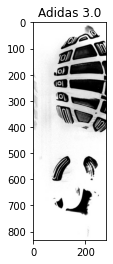

In [131]:
showResult(predicted_y[0],shoes_test.iloc[0], True)

[7.9044034e-09 5.5940332e-11 1.8461769e-15 9.9999976e-01 2.2673422e-07
 4.0878663e-12 9.3712210e-16]
[3 4 0 1 5 2 6]
[2.3107323e-01 7.5913107e-01 4.0065584e-07 4.3763909e-03 5.4068952e-03
 1.1864245e-05 8.7441826e-08]
[1 0 4 3 5 2 6]
[3.9835125e-01 8.9958578e-02 1.0146574e-03 4.7263354e-01 3.7680659e-02
 2.8845543e-04 7.2857314e-05]
[3 0 1 4 2 5 6]
[1.0920948e-02 6.8738973e-03 9.9263197e-08 4.1889714e-04 9.8178607e-01
 2.0448196e-09 1.2746925e-07]
[4 0 1 3 6 2 5]
[0.08999749 0.02887833 0.00639416 0.0106503  0.43868783 0.00062198
 0.42476985]
[4 6 0 1 3 2 5]


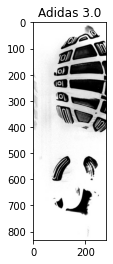

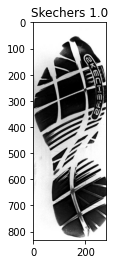

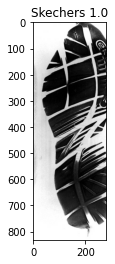

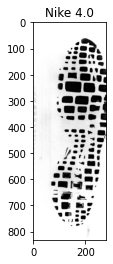

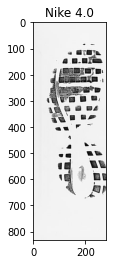

In [132]:
for i in range(5):
    showResult(predicted_y[i],shoes_test.iloc[i], True)

In [150]:
#Calular porcentaje que aparecen en las 3 primera posiciones 

def getXfirstOk(predicted, test, x):
    sort_index = np.argsort(-predicted)
    if test['factor_brand'] in sort_index[:x]:
        return True
    return False
        

In [143]:
getXfirstOk(predicted_y[0], shoes_test.iloc[0],3)

True

In [151]:
def checkAccuracyFirstPositions(predicted_y, shoes_test, x):
    total = len(predicted_y)
    ok = 0
    for i in range(total):
        if getXfirstOk(predicted_y[i],shoes_test.iloc[i],x):
            ok = ok+1

    print(ok)
    print(ok/total)


In [155]:
def executeModel(aumentation, gray, binary, crop, epoch):
   
    modelTest = createModelTest(not gray)
    
    modelTest.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    #Configurar el preprocesado que se hará en las imágenes desntro del Generator.
    trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    print(" ")
    print('Training model with aumentation:'+str(aumentation)+', gray:'+str(gray)+', binary:'+str(binary)+', crop:'+str(crop)+' and epochs = '+str(epoch))
    trainHistory = modelTest.fit(trainGenerator,validation_data=valGenerator, epochs=epoch)
    
    plot_history(trainHistory)
    
    predicted_y = modelTest.predict(testGenerator)
    print("Test evaluation:")
    print(modelTest.evaluate(testGenerator))
    print("% of correct brand in the first 3 positions:")
    print(checkAccuracyFirstPositions(predicted_y, shoes_test,3))
    
    

In [171]:
def executeModelData(aumentation, gray, binary, crop, epoch, train, test, val, df, n):
   
    modelTest = createModelTest(not gray, n)
    
    modelTest.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    #Configurar el preprocesado que se hará en las imágenes desntro del Generator.
    trainGenerator=DataGenerator2dFootwear(train['X'].tolist(),df,aumentation, "images/", gray, binary, crop)
    testGenerator=DataGenerator2dFootwear(test['X'].tolist(),df,aumentation, "images/", gray, binary, crop)
    valGenerator=DataGenerator2dFootwear(val['X'].tolist(),df,aumentation, "images/", gray, binary, crop)
    print(" ")
    print('Training model with aumentation:'+str(aumentation)+', gray:'+str(gray)+', binary:'+str(binary)+', crop:'+str(crop)+' and epochs = '+str(epoch))
    trainHistory = modelTest.fit(trainGenerator,validation_data=valGenerator, epochs=epoch)
    
    plot_history(trainHistory)
    
    predicted_y = modelTest.predict(testGenerator)
    print("Test evaluation:")
    print(modelTest.evaluate(testGenerator))
    print("% of correct brand in the first 3 positions:")
    print(checkAccuracyFirstPositions(predicted_y, test,3))

### Experimentos con diferentes valores de epoch y diferentes preprocesos en las imágenes


 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 56s 993ms/step - loss: 1.9069 - accuracy: 0.2647 - val_loss: 1.8830 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 57s 1s/step - loss: 1.8777 - accuracy: 0.2760 - val_loss: 1.8581 - val_accuracy: 0.3333
Epoch 3/10
53/53 [==============================] - 109s 2s/step - loss: 1.8647 - accuracy: 0.3006 - val_loss: 1.8385 - val_accuracy: 0.3333
Epoch 4/10
53/53 [==============================] - 89s 2s/step - loss: 1.8539 - accuracy: 0.2930 - val_loss: 1.8618 - val_accuracy: 0.3333
Epoch 5/10
53/53 [==============================] - 75s 1s/step - loss: 1.8570 - accuracy: 0.3025 - val_loss: 1.9045 - val_accuracy: 0.3333
Epoch 6/10
53/53 [==============================] - 73s 1s/step - loss: 1.8563 - accuracy: 0.3025 - val_loss: 1.8437 - val_accuracy: 0.3333
Epoch 7/10
53/53 [==============================] - 75s 1s/ste

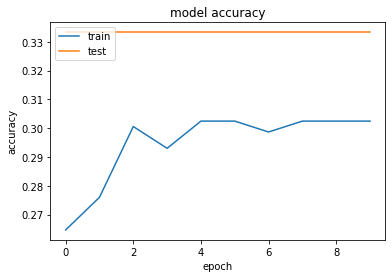

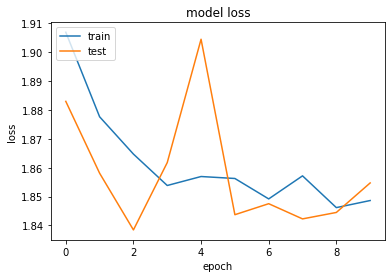

16/16 [==============================] - 5s 282ms/step
Test evaluation:
16/16 [==============================] - 5s 297ms/step - loss: 1.8416 - accuracy: 0.3312
[1.841644525527954, 0.3311688303947449]
% of correct brand in the first 3 positions:
97
0.6298701298701299
None


In [460]:
executeModel(False, False, False, False, 10)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 78s 1s/step - loss: 4.3415 - accuracy: 0.2401 - val_loss: 1.7591 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 75s 1s/step - loss: 1.8051 - accuracy: 0.2987 - val_loss: 1.7831 - val_accuracy: 0.2989
Epoch 3/10
53/53 [==============================] - 74s 1s/step - loss: 1.7308 - accuracy: 0.3119 - val_loss: 1.5948 - val_accuracy: 0.3563
Epoch 4/10
53/53 [==============================] - 71s 1s/step - loss: 1.6568 - accuracy: 0.3176 - val_loss: 1.5219 - val_accuracy: 0.4023
Epoch 5/10
53/53 [==============================] - 74s 1s/step - loss: 1.5729 - accuracy: 0.3837 - val_loss: 1.5147 - val_accuracy: 0.3908
Epoch 6/10
53/53 [==============================] - 74s 1s/step - loss: 1.5318 - accuracy: 0.3611 - val_loss: 1.3804 - val_accuracy: 0.4713
Epoch 7/10
53/53 [==============================] - 72s 1s/step - l

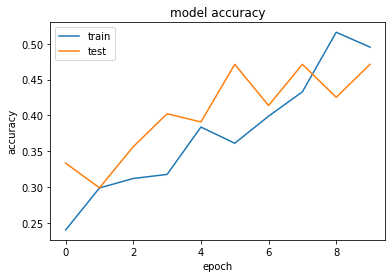

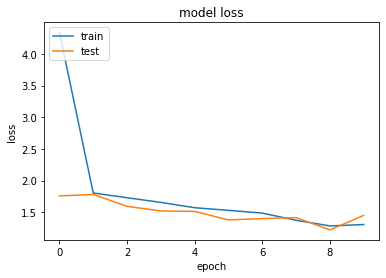

16/16 [==============================] - 9s 522ms/step
Test evaluation:
16/16 [==============================] - 9s 538ms/step - loss: 1.6539 - accuracy: 0.4545
[1.6538931131362915, 0.4545454680919647]
% of correct brand in the first 3 positions:
92
0.5974025974025974
None


In [461]:
executeModel(True, False, False, False, 10)

 
Training model with aumentation:False, gray:True, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 65s 1s/step - loss: 1.8723 - accuracy: 0.2836 - val_loss: 1.8420 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 60s 1s/step - loss: 1.8711 - accuracy: 0.3043 - val_loss: 1.8952 - val_accuracy: 0.3333
Epoch 3/10
53/53 [==============================] - 60s 1s/step - loss: 1.8503 - accuracy: 0.3025 - val_loss: 1.8553 - val_accuracy: 0.3333
Epoch 4/10
53/53 [==============================] - 59s 1s/step - loss: 1.8393 - accuracy: 0.2987 - val_loss: 1.8536 - val_accuracy: 0.3333
Epoch 5/10
53/53 [==============================] - 59s 1s/step - loss: 1.8617 - accuracy: 0.2930 - val_loss: 1.8507 - val_accuracy: 0.3333
Epoch 6/10
53/53 [==============================] - 59s 1s/step - loss: 1.8532 - accuracy: 0.3006 - val_loss: 1.8586 - val_accuracy: 0.3333
Epoch 7/10
53/53 [==============================] - 58s 1s/step - l

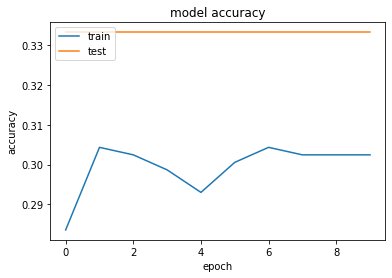

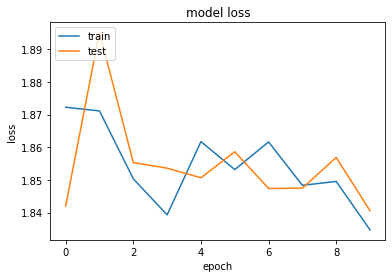

16/16 [==============================] - 4s 224ms/step
Test evaluation:
16/16 [==============================] - 4s 230ms/step - loss: 1.8248 - accuracy: 0.3312
[1.8247859477996826, 0.3311688303947449]
% of correct brand in the first 3 positions:
97
0.6298701298701299
None


In [462]:
executeModel(False, True, False, False, 10)

 
Training model with aumentation:False, gray:True, binary:True, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 79s 1s/step - loss: 2.3510 - accuracy: 0.2703 - val_loss: 1.8599 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 52s 976ms/step - loss: 1.7261 - accuracy: 0.3497 - val_loss: 1.4955 - val_accuracy: 0.4253
Epoch 3/10
53/53 [==============================] - 51s 961ms/step - loss: 1.4232 - accuracy: 0.4802 - val_loss: 1.2958 - val_accuracy: 0.4943
Epoch 4/10
53/53 [==============================] - 52s 972ms/step - loss: 1.0007 - accuracy: 0.6446 - val_loss: 0.9699 - val_accuracy: 0.6207
Epoch 5/10
53/53 [==============================] - 52s 986ms/step - loss: 0.7885 - accuracy: 0.7070 - val_loss: 1.2495 - val_accuracy: 0.6207
Epoch 6/10
53/53 [==============================] - 54s 1s/step - loss: 0.6689 - accuracy: 0.7505 - val_loss: 1.0293 - val_accuracy: 0.6552
Epoch 7/10
53/53 [==============================] - 53s 

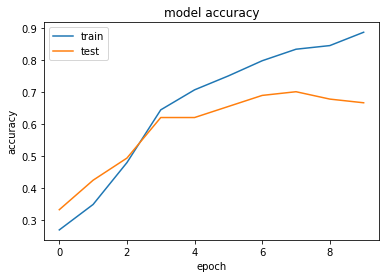

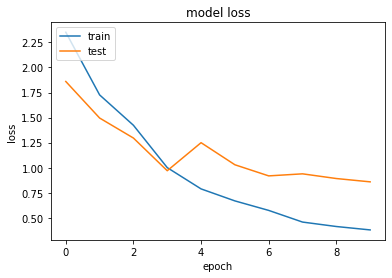

16/16 [==============================] - 3s 198ms/step
Test evaluation:
16/16 [==============================] - 3s 200ms/step - loss: 1.1299 - accuracy: 0.6364
[1.1299312114715576, 0.6363636255264282]
% of correct brand in the first 3 positions:
137
0.8896103896103896
None


In [463]:
executeModel(False, True, True, False, 10)

 
Training model with aumentation:True, gray:True, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 70s 1s/step - loss: 2.4213 - accuracy: 0.2533 - val_loss: 1.8591 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 62s 1s/step - loss: 1.8014 - accuracy: 0.2892 - val_loss: 1.7126 - val_accuracy: 0.3218
Epoch 3/10
53/53 [==============================] - 61s 1s/step - loss: 1.7165 - accuracy: 0.2987 - val_loss: 1.6068 - val_accuracy: 0.3448
Epoch 4/10
53/53 [==============================] - 62s 1s/step - loss: 1.6371 - accuracy: 0.3459 - val_loss: 1.6777 - val_accuracy: 0.4253
Epoch 5/10
53/53 [==============================] - 60s 1s/step - loss: 1.5643 - accuracy: 0.3894 - val_loss: 1.5129 - val_accuracy: 0.4713
Epoch 6/10
53/53 [==============================] - 67s 1s/step - loss: 1.4996 - accuracy: 0.4329 - val_loss: 1.4343 - val_accuracy: 0.4598
Epoch 7/10
53/53 [==============================] - 106s 2s/step - l

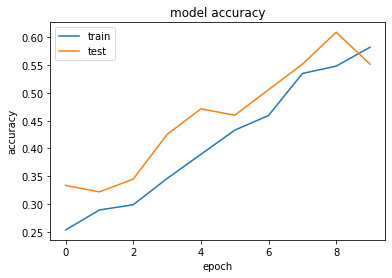

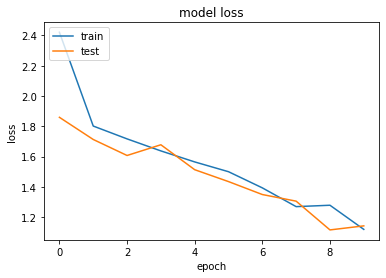

16/16 [==============================] - 6s 294ms/step
Test evaluation:
16/16 [==============================] - 5s 312ms/step - loss: 1.1515 - accuracy: 0.5130
[1.1515398025512695, 0.5129870176315308]
% of correct brand in the first 3 positions:
79
0.512987012987013
None


In [471]:
executeModel(True, True, False, False, 10)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 56s 983ms/step - loss: 2.2715 - accuracy: 0.2760 - val_loss: 1.7214 - val_accuracy: 0.3563
Epoch 2/10
53/53 [==============================] - 53s 996ms/step - loss: 1.4275 - accuracy: 0.4329 - val_loss: 1.1458 - val_accuracy: 0.5517
Epoch 3/10
53/53 [==============================] - 53s 988ms/step - loss: 0.8800 - accuracy: 0.6862 - val_loss: 1.1601 - val_accuracy: 0.5977
Epoch 4/10
53/53 [==============================] - 54s 1s/step - loss: 0.7207 - accuracy: 0.7713 - val_loss: 1.1748 - val_accuracy: 0.6092
Epoch 5/10
53/53 [==============================] - 53s 994ms/step - loss: 0.4323 - accuracy: 0.8658 - val_loss: 1.3042 - val_accuracy: 0.7011
Epoch 6/10
53/53 [==============================] - 53s 1s/step - loss: 0.3196 - accuracy: 0.8960 - val_loss: 1.1201 - val_accuracy: 0.6782
Epoch 7/10
53/53 [==============================] - 54s 1

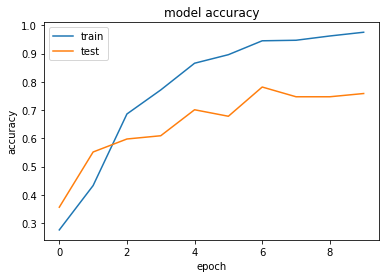

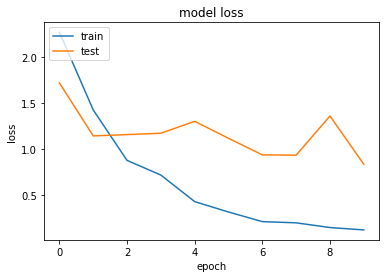

16/16 [==============================] - 3s 201ms/step
Test evaluation:
16/16 [==============================] - 3s 196ms/step - loss: 0.7390 - accuracy: 0.7403
[0.738982081413269, 0.7402597665786743]
% of correct brand in the first 3 positions:
149
0.9675324675324676
None


In [464]:
executeModel(False, True, True, True, 10)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 70s 1s/step - loss: 4.4094 - accuracy: 0.2325 - val_loss: 1.8973 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 66s 1s/step - loss: 1.9097 - accuracy: 0.3157 - val_loss: 1.9134 - val_accuracy: 0.3103
Epoch 3/10
53/53 [==============================] - 63s 1s/step - loss: 1.8362 - accuracy: 0.3025 - val_loss: 1.8134 - val_accuracy: 0.3333
Epoch 4/10
53/53 [==============================] - 62s 1s/step - loss: 1.8044 - accuracy: 0.3214 - val_loss: 1.8021 - val_accuracy: 0.3103
Epoch 5/10
53/53 [==============================] - 65s 1s/step - loss: 1.8558 - accuracy: 0.3025 - val_loss: 1.8269 - val_accuracy: 0.3333
Epoch 6/10
53/53 [==============================] - 65s 1s/step - loss: 1.7787 - accuracy: 0.3289 - val_loss: 1.7170 - val_accuracy: 0.3563
Epoch 7/10
53/53 [==============================] - 66s 1s/step - loss

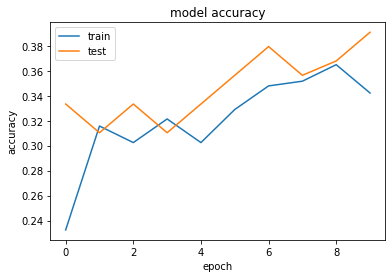

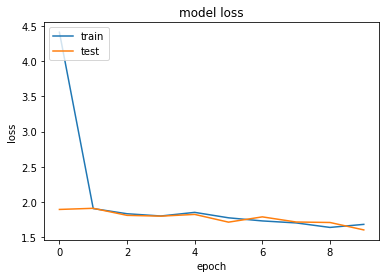

16/16 [==============================] - 6s 373ms/step
Test evaluation:
16/16 [==============================] - 7s 424ms/step - loss: 1.6327 - accuracy: 0.3831
[1.6326556205749512, 0.38311687111854553]
% of correct brand in the first 3 positions:
94
0.6103896103896104
None


In [470]:
executeModel(True, True, True, True, 10)

 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 59s 1s/step - loss: 1.9028 - accuracy: 0.2401 - val_loss: 1.8766 - val_accuracy: 0.3333
Epoch 2/25
53/53 [==============================] - 74s 1s/step - loss: 1.8666 - accuracy: 0.2911 - val_loss: 1.8399 - val_accuracy: 0.3333
Epoch 3/25
53/53 [==============================] - 78s 1s/step - loss: 1.8529 - accuracy: 0.3006 - val_loss: 1.8447 - val_accuracy: 0.3333
Epoch 4/25
53/53 [==============================] - 71s 1s/step - loss: 1.8764 - accuracy: 0.2930 - val_loss: 1.8470 - val_accuracy: 0.3333
Epoch 5/25
53/53 [==============================] - 68s 1s/step - loss: 1.8588 - accuracy: 0.3025 - val_loss: 1.8284 - val_accuracy: 0.3333
Epoch 6/25
53/53 [==============================] - 67s 1s/step - loss: 1.8584 - accuracy: 0.3025 - val_loss: 1.8405 - val_accuracy: 0.3333
Epoch 7/25
53/53 [==============================] - 64s 1s/step - 

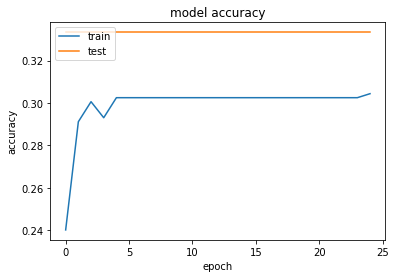

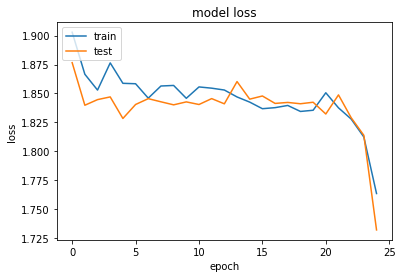

16/16 [==============================] - 5s 290ms/step
Test evaluation:
16/16 [==============================] - 6s 370ms/step - loss: 1.7299 - accuracy: 0.3312
[1.7299422025680542, 0.3311688303947449]
% of correct brand in the first 3 positions:
97
0.6298701298701299
None


In [465]:
executeModel(False, False, False, False, 25)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 81s 1s/step - loss: 3.3676 - accuracy: 0.2647 - val_loss: 1.8782 - val_accuracy: 0.3333
Epoch 2/25
53/53 [==============================] - 94s 2s/step - loss: 1.8057 - accuracy: 0.2798 - val_loss: 1.7696 - val_accuracy: 0.3333
Epoch 3/25
53/53 [==============================] - 84s 2s/step - loss: 1.6621 - accuracy: 0.3365 - val_loss: 1.6796 - val_accuracy: 0.3333
Epoch 4/25
53/53 [==============================] - 78s 1s/step - loss: 1.4856 - accuracy: 0.4197 - val_loss: 1.4189 - val_accuracy: 0.4253
Epoch 5/25
53/53 [==============================] - 72s 1s/step - loss: 1.4414 - accuracy: 0.4367 - val_loss: 1.2754 - val_accuracy: 0.4598
Epoch 6/25
53/53 [==============================] - 76s 1s/step - loss: 1.2771 - accuracy: 0.4915 - val_loss: 1.3979 - val_accuracy: 0.4713
Epoch 7/25
53/53 [==============================] - 80s 2s/step - l

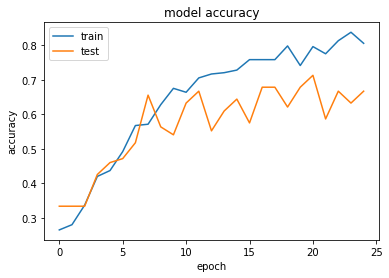

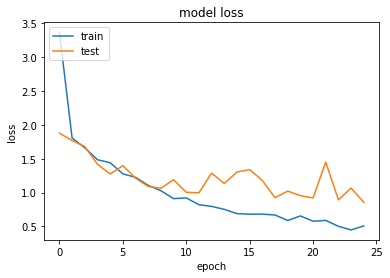

16/16 [==============================] - 9s 549ms/step
Test evaluation:
16/16 [==============================] - 9s 569ms/step - loss: 0.7312 - accuracy: 0.7273
[0.7312448024749756, 0.7272727489471436]
% of correct brand in the first 3 positions:
89
0.577922077922078
None


In [466]:
executeModel(True, False, False, False, 25)

 
Training model with aumentation:False, gray:True, binary:False, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 65s 1s/step - loss: 1.9029 - accuracy: 0.2439 - val_loss: 1.8329 - val_accuracy: 0.3333
Epoch 2/25
53/53 [==============================] - 57s 1s/step - loss: 1.8767 - accuracy: 0.2760 - val_loss: 1.8206 - val_accuracy: 0.3333
Epoch 3/25
53/53 [==============================] - 59s 1s/step - loss: 1.8537 - accuracy: 0.3119 - val_loss: 1.8360 - val_accuracy: 0.3333
Epoch 4/25
53/53 [==============================] - 60s 1s/step - loss: 1.8635 - accuracy: 0.3006 - val_loss: 1.8477 - val_accuracy: 0.3333
Epoch 5/25
53/53 [==============================] - 59s 1s/step - loss: 1.8612 - accuracy: 0.3006 - val_loss: 1.8372 - val_accuracy: 0.3333
Epoch 6/25
53/53 [==============================] - 61s 1s/step - loss: 1.8515 - accuracy: 0.3006 - val_loss: 1.8436 - val_accuracy: 0.3333
Epoch 7/25
53/53 [==============================] - 58s 1s/step - l

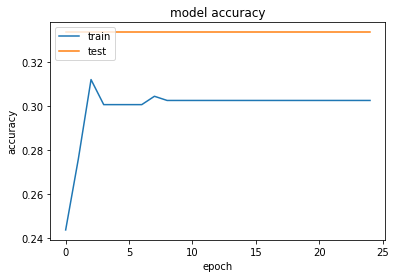

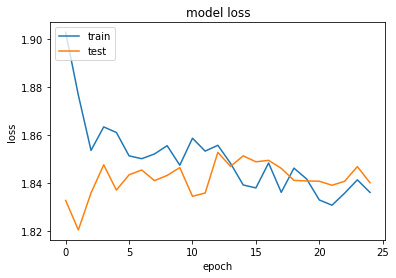

16/16 [==============================] - 3s 199ms/step
Test evaluation:
16/16 [==============================] - 5s 279ms/step - loss: 1.8261 - accuracy: 0.3312
[1.826066255569458, 0.3311688303947449]
% of correct brand in the first 3 positions:
97
0.6298701298701299
None


In [467]:
executeModel(False, True, False, False, 25)

 
Training model with aumentation:False, gray:True, binary:True, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 64s 1s/step - loss: 2.2998 - accuracy: 0.2609 - val_loss: 1.6451 - val_accuracy: 0.3333
Epoch 2/25
53/53 [==============================] - 57s 1s/step - loss: 1.5276 - accuracy: 0.4197 - val_loss: 1.3818 - val_accuracy: 0.4713
Epoch 3/25
53/53 [==============================] - 57s 1s/step - loss: 1.0998 - accuracy: 0.6125 - val_loss: 1.2970 - val_accuracy: 0.5517
Epoch 4/25
53/53 [==============================] - 56s 1s/step - loss: 0.8210 - accuracy: 0.7032 - val_loss: 1.3018 - val_accuracy: 0.5402
Epoch 5/25
53/53 [==============================] - 56s 1s/step - loss: 0.6247 - accuracy: 0.7921 - val_loss: 1.1787 - val_accuracy: 0.6322
Epoch 6/25
53/53 [==============================] - 56s 1s/step - loss: 0.3893 - accuracy: 0.8733 - val_loss: 1.4717 - val_accuracy: 0.5747
Epoch 7/25
53/53 [==============================] - 56s 1s/step - lo

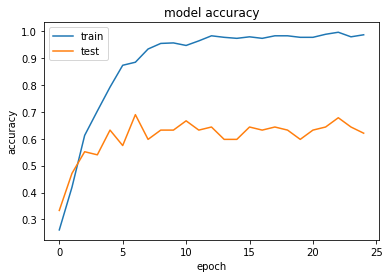

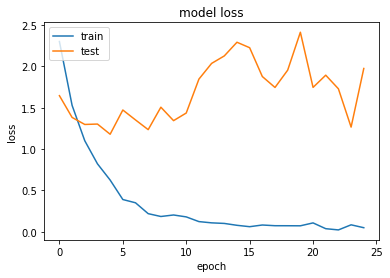

16/16 [==============================] - 3s 199ms/step
Test evaluation:
16/16 [==============================] - 3s 197ms/step - loss: 2.5348 - accuracy: 0.5844
[2.534780263900757, 0.5844155550003052]
% of correct brand in the first 3 positions:
132
0.8571428571428571
None


In [468]:
executeModel(False, True, True, False, 25)

In [ ]:
executeModel(True, True, False, False, 25)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 25
Epoch 1/25
53/53 [==============================] - 59s 1s/step - loss: 2.3622 - accuracy: 0.2684 - val_loss: 1.6440 - val_accuracy: 0.3563
Epoch 2/25
53/53 [==============================] - 56s 1s/step - loss: 1.3603 - accuracy: 0.4972 - val_loss: 1.2239 - val_accuracy: 0.5977
Epoch 3/25
53/53 [==============================] - 60s 1s/step - loss: 0.8507 - accuracy: 0.6824 - val_loss: 1.1792 - val_accuracy: 0.6322
Epoch 4/25
53/53 [==============================] - 60s 1s/step - loss: 0.5519 - accuracy: 0.8242 - val_loss: 1.1181 - val_accuracy: 0.6782
Epoch 5/25
53/53 [==============================] - 59s 1s/step - loss: 0.3886 - accuracy: 0.8752 - val_loss: 0.9903 - val_accuracy: 0.7241
Epoch 6/25
53/53 [==============================] - 59s 1s/step - loss: 0.2839 - accuracy: 0.9187 - val_loss: 0.8305 - val_accuracy: 0.6667
Epoch 7/25
53/53 [==============================] - 60s 1s/step - los

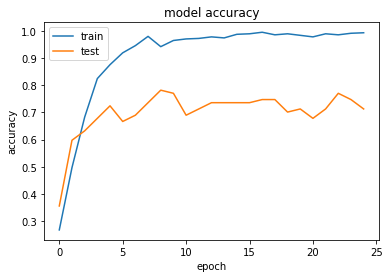

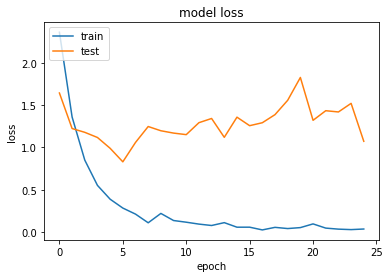

16/16 [==============================] - 4s 223ms/step
Test evaluation:
16/16 [==============================] - 4s 225ms/step - loss: 0.8889 - accuracy: 0.8247
[0.8888569474220276, 0.8246753215789795]
% of correct brand in the first 3 positions:
152
0.987012987012987
None


In [469]:
executeModel(False, True, True, True, 25)

In [ ]:
executeModel(True, True, True, True, 25)

 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 5
Epoch 1/5
53/53 [==============================] - 60s 1s/step - loss: 1.8963 - accuracy: 0.2968 - val_loss: 1.8665 - val_accuracy: 0.2759
Epoch 2/5
53/53 [==============================] - 62s 1s/step - loss: 1.8702 - accuracy: 0.3176 - val_loss: 1.8747 - val_accuracy: 0.2759
Epoch 3/5
53/53 [==============================] - 61s 1s/step - loss: 1.8850 - accuracy: 0.3176 - val_loss: 1.8732 - val_accuracy: 0.2759
Epoch 4/5
53/53 [==============================] - 60s 1s/step - loss: 1.8491 - accuracy: 0.3157 - val_loss: 1.8654 - val_accuracy: 0.2759
Epoch 5/5
53/53 [==============================] - 66s 1s/step - loss: 1.8484 - accuracy: 0.3176 - val_loss: 1.8727 - val_accuracy: 0.2759


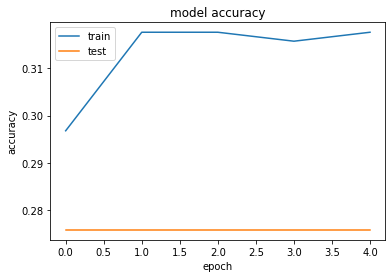

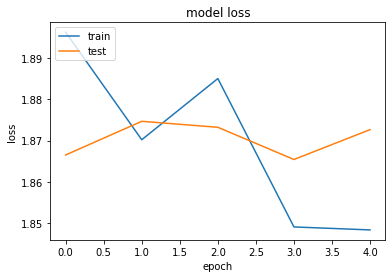

16/16 [==============================] - 5s 297ms/step
Test evaluation:
16/16 [==============================] - 5s 306ms/step - loss: 1.8206 - accuracy: 0.3117
[1.8206173181533813, 0.31168830394744873]
% of correct brand in the first 3 positions:
101
0.6558441558441559
None


In [157]:
executeModel(False, False, False, False, 5)

 
Training model with aumentation:False, gray:True, binary:True, crop:False and epochs = 5
Epoch 1/5
53/53 [==============================] - 72s 1s/step - loss: 2.3549 - accuracy: 0.2987 - val_loss: 1.9282 - val_accuracy: 0.2759
Epoch 2/5
53/53 [==============================] - 65s 1s/step - loss: 1.7699 - accuracy: 0.3251 - val_loss: 1.6013 - val_accuracy: 0.4598
Epoch 3/5
53/53 [==============================] - 60s 1s/step - loss: 1.4122 - accuracy: 0.4612 - val_loss: 1.3452 - val_accuracy: 0.5862
Epoch 4/5
53/53 [==============================] - 63s 1s/step - loss: 1.0988 - accuracy: 0.6125 - val_loss: 1.2778 - val_accuracy: 0.5632
Epoch 5/5
53/53 [==============================] - 63s 1s/step - loss: 0.7832 - accuracy: 0.7259 - val_loss: 1.0405 - val_accuracy: 0.6322


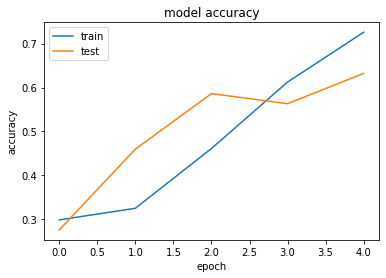

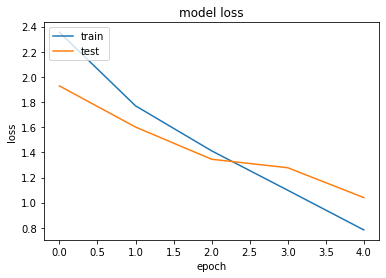

16/16 [==============================] - 4s 228ms/step
Test evaluation:
16/16 [==============================] - 4s 255ms/step - loss: 1.2275 - accuracy: 0.6169
[1.2275323867797852, 0.6168830990791321]
% of correct brand in the first 3 positions:
137
0.8896103896103896
None


In [158]:
executeModel(False, True, True, False, 5)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 5
Epoch 1/5
53/53 [==============================] - 67s 1s/step - loss: 13.4743 - accuracy: 0.1493 - val_loss: 13.3391 - val_accuracy: 0.1724
Epoch 2/5
53/53 [==============================] - 65s 1s/step - loss: 13.5587 - accuracy: 0.1588 - val_loss: 13.3391 - val_accuracy: 0.1724
Epoch 3/5
53/53 [==============================] - 58s 1s/step - loss: 13.5155 - accuracy: 0.1588 - val_loss: 13.3391 - val_accuracy: 0.1724
Epoch 4/5
53/53 [==============================] - 69s 1s/step - loss: 12.9879 - accuracy: 0.1323 - val_loss: 2.2248 - val_accuracy: 0.1724
Epoch 5/5
53/53 [==============================] - 73s 1s/step - loss: 1.9331 - accuracy: 0.2798 - val_loss: 1.9027 - val_accuracy: 0.2759


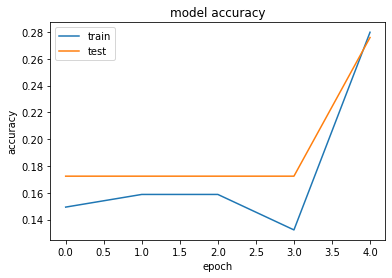

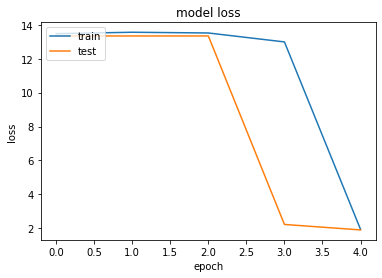

16/16 [==============================] - 5s 273ms/step
Test evaluation:
16/16 [==============================] - 5s 291ms/step - loss: 1.8933 - accuracy: 0.3117
[1.8932996988296509, 0.31168830394744873]
% of correct brand in the first 3 positions:
101
0.6558441558441559
None


In [167]:
executeModel(False, True, True, True, 5)

In [ ]:
executeModel(False, False, False, False, 50)

In [ ]:
executeModel(False, True, True, False, 50)

In [ ]:
executeModel(False, True, True, True, 50)

### Experimentos con diferentes valores de muestras mínimas por marca



In [168]:

def returnDataByMinSample ( minSample, deleteNone=True):
    dfbrandMin, dfbrandoneMin = filterMinSamples(dfbrandall, minSample)
    num_classesMin=len(dfbrandMin)
    df_shoe_brandMin = filterBrands(df_shoe_brand_all,dfbrandoneMin, deleteNone)
    print(df_shoe_brandMin)

    shoes_trainMin, shoes_testMin, shoes_valMin = split_datafiles(df_shoe_brandMin)

    while checkBalancedSample(shoes_trainMin, shoes_testMin, shoes_valMin) == False:
        shoes_trainMin, shoes_testMin, shoes_valMin = split_datafiles(df_shoe_brandMin)
    
    return num_classesMin, df_shoe_brandMin, shoes_trainMin, shoes_testMin, shoes_valMin

In [169]:
num_classes3, df_shoe_brand3,shoes_train3, shoes_test3, shoes_val3 = returnDataByMinSample(3)

Brands with at least 3 samples: 12
Brands with only 1 register: 47
                     X         y factor_brand
0     021_05_R_03.jpeg  Champion          0.0
2     026_06_R_01.jpeg      Keen          1.0
3     009_08_R_05.jpeg     Asics          2.0
8     010_01_L_01.jpeg  Skechers          3.0
11    021_02_R_04.jpeg  Champion          0.0
...                ...       ...          ...
1490  020_02_L_01.jpeg  Skechers          3.0
1493  011_01_R_04.jpeg    Adidas          7.0
1494  026_07_L_03.jpeg   Saucony         11.0
1496  018_04_R_02.jpeg    Sperry          5.0
1499  025_03_L_04.jpeg      Nike          8.0

[930 rows x 3 columns]


 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
64/64 [==============================] - 87s 1s/step - loss: 2.3315 - accuracy: 0.2254 - val_loss: 2.3182 - val_accuracy: 0.2762
Epoch 2/10
64/64 [==============================] - 91s 1s/step - loss: 2.2838 - accuracy: 0.2567 - val_loss: 2.3204 - val_accuracy: 0.2762
Epoch 3/10
64/64 [==============================] - 102s 2s/step - loss: 2.2570 - accuracy: 0.2598 - val_loss: 2.3318 - val_accuracy: 0.2762
Epoch 4/10
64/64 [==============================] - 92s 1s/step - loss: 2.2794 - accuracy: 0.2504 - val_loss: 2.3045 - val_accuracy: 0.2762
Epoch 5/10
64/64 [==============================] - 94s 1s/step - loss: 2.2719 - accuracy: 0.2520 - val_loss: 2.3068 - val_accuracy: 0.2762
Epoch 6/10
64/64 [==============================] - 91s 1s/step - loss: 2.2761 - accuracy: 0.2567 - val_loss: 2.3159 - val_accuracy: 0.2762
Epoch 7/10
64/64 [==============================] - 84s 1s/step -

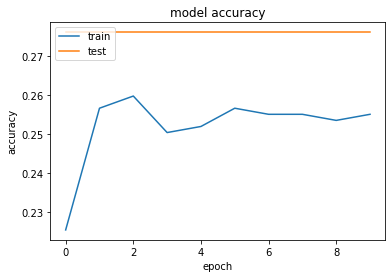

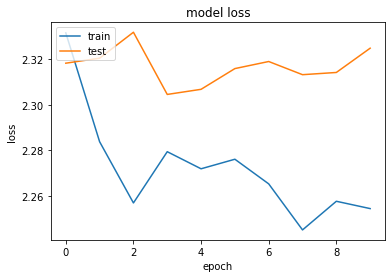

19/19 [==============================] - 15s 710ms/step
Test evaluation:
19/19 [==============================] - 7s 358ms/step - loss: 2.2672 - accuracy: 0.2581
[2.267219066619873, 0.25806450843811035]
% of correct brand in the first 3 positions:
99
0.532258064516129
None


In [173]:
executeModelData(False, False, False, False, 10, shoes_train3, shoes_test3, shoes_val3, df_shoe_brand3,num_classes3)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
64/64 [==============================] - 94s 1s/step - loss: 3.8610 - accuracy: 0.1987 - val_loss: 2.2110 - val_accuracy: 0.2762
Epoch 2/10
64/64 [==============================] - 92s 1s/step - loss: 2.1970 - accuracy: 0.2676 - val_loss: 2.1200 - val_accuracy: 0.2762
Epoch 3/10
64/64 [==============================] - 104s 2s/step - loss: 2.0801 - accuracy: 0.2973 - val_loss: 1.9878 - val_accuracy: 0.3524
Epoch 4/10
64/64 [==============================] - 120s 2s/step - loss: 1.9203 - accuracy: 0.3349 - val_loss: 1.9142 - val_accuracy: 0.3429
Epoch 5/10
64/64 [==============================] - 96s 1s/step - loss: 1.7709 - accuracy: 0.4069 - val_loss: 1.7958 - val_accuracy: 0.3905
Epoch 6/10
64/64 [==============================] - 96s 2s/step - loss: 1.5981 - accuracy: 0.4710 - val_loss: 1.7164 - val_accuracy: 0.4476
Epoch 7/10
64/64 [==============================] - 102s 2s/step 

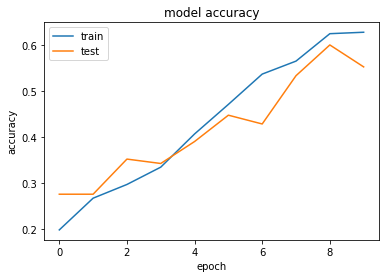

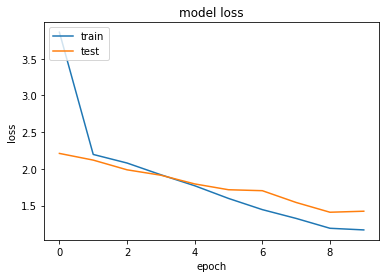

19/19 [==============================] - 15s 800ms/step
Test evaluation:
19/19 [==============================] - 12s 600ms/step - loss: 1.2419 - accuracy: 0.5914
[1.2418514490127563, 0.5913978219032288]
% of correct brand in the first 3 positions:
62
0.3333333333333333
None


In [175]:
executeModelData(True, False, False, False, 10, shoes_train3, shoes_test3, shoes_val3, df_shoe_brand3,num_classes3)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
64/64 [==============================] - 92s 1s/step - loss: 5.5575 - accuracy: 0.2426 - val_loss: 2.1820 - val_accuracy: 0.2381
Epoch 2/10
64/64 [==============================] - 92s 1s/step - loss: 1.7603 - accuracy: 0.4038 - val_loss: 1.5213 - val_accuracy: 0.4857
Epoch 3/10
64/64 [==============================] - 95s 1s/step - loss: 1.1863 - accuracy: 0.6228 - val_loss: 1.1296 - val_accuracy: 0.6762
Epoch 4/10
64/64 [==============================] - 94s 1s/step - loss: 0.7779 - accuracy: 0.7543 - val_loss: 1.0505 - val_accuracy: 0.6857
Epoch 5/10
64/64 [==============================] - 95s 1s/step - loss: 0.6239 - accuracy: 0.8028 - val_loss: 0.9830 - val_accuracy: 0.7429
Epoch 6/10
64/64 [==============================] - 89s 1s/step - loss: 0.4411 - accuracy: 0.8654 - val_loss: 1.0090 - val_accuracy: 0.6762
Epoch 7/10
64/64 [==============================] - 94s 1s/step - los

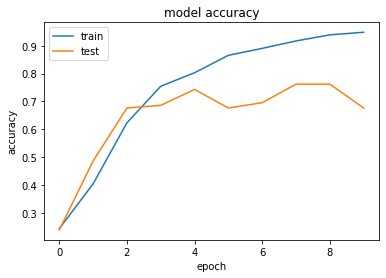

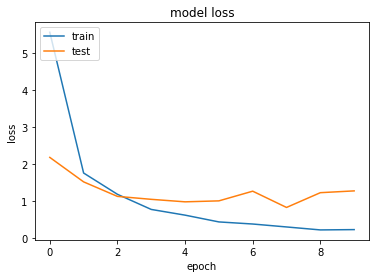

19/19 [==============================] - 6s 298ms/step
Test evaluation:
19/19 [==============================] - 7s 334ms/step - loss: 1.8119 - accuracy: 0.6559
[1.8119466304779053, 0.6559139490127563]
% of correct brand in the first 3 positions:
166
0.8924731182795699
None


In [176]:
executeModelData(False, True, True, True, 10, shoes_train3, shoes_test3, shoes_val3, df_shoe_brand3,num_classes3)

In [177]:
num_classes2, df_shoe_brand2,shoes_train2, shoes_test2, shoes_val2 = returnDataByMinSample(2)

Brands with at least 2 samples: 19
Brands with only 1 register: 40
                     X         y factor_brand
0     021_05_R_03.jpeg  Champion          0.0
2     026_06_R_01.jpeg      Keen          1.0
3     009_08_R_05.jpeg     Asics          2.0
7     012_04_L_01.jpeg  Prospecs          3.0
8     010_01_L_01.jpeg  Skechers          4.0
...                ...       ...          ...
1493  011_01_R_04.jpeg    Adidas          8.0
1494  026_07_L_03.jpeg   Saucony         13.0
1496  018_04_R_02.jpeg    Sperry          6.0
1497  012_05_R_03.jpeg  Namuhana         16.0
1499  025_03_L_04.jpeg      Nike          9.0

[1070 rows x 3 columns]


 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
74/74 [==============================] - 113s 1s/step - loss: 2.7825 - accuracy: 0.1957 - val_loss: 2.5446 - val_accuracy: 0.2583
Epoch 2/10
74/74 [==============================] - 110s 1s/step - loss: 2.7231 - accuracy: 0.1957 - val_loss: 2.6192 - val_accuracy: 0.2583
Epoch 3/10
74/74 [==============================] - 113s 2s/step - loss: 2.6992 - accuracy: 0.2174 - val_loss: 2.5182 - val_accuracy: 0.2583
Epoch 4/10
74/74 [==============================] - 98s 1s/step - loss: 2.6849 - accuracy: 0.2133 - val_loss: 2.5364 - val_accuracy: 0.2583
Epoch 5/10
74/74 [==============================] - 103s 1s/step - loss: 2.6760 - accuracy: 0.2160 - val_loss: 2.5341 - val_accuracy: 0.2583
Epoch 6/10
74/74 [==============================] - 103s 1s/step - loss: 2.6694 - accuracy: 0.2160 - val_loss: 2.5082 - val_accuracy: 0.2583
Epoch 7/10
74/74 [==============================] - 99s 1s/st

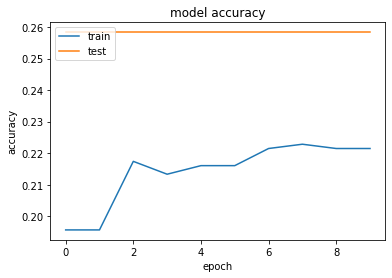

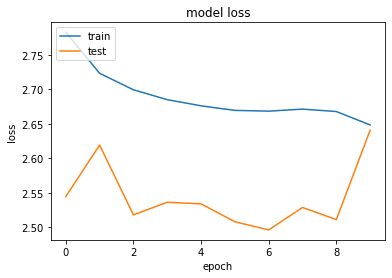

22/22 [==============================] - 8s 337ms/step
Test evaluation:
22/22 [==============================] - 8s 327ms/step - loss: 2.6982 - accuracy: 0.2150
[2.6981639862060547, 0.21495327353477478]
% of correct brand in the first 3 positions:
99
0.46261682242990654
None


In [178]:
executeModelData(False, False, False, False, 10, shoes_train2, shoes_test2, shoes_val2, df_shoe_brand2,num_classes2)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
74/74 [==============================] - 117s 2s/step - loss: 3.6496 - accuracy: 0.1739 - val_loss: 2.5714 - val_accuracy: 0.2583
Epoch 2/10
74/74 [==============================] - 113s 2s/step - loss: 2.6573 - accuracy: 0.2092 - val_loss: 2.3374 - val_accuracy: 0.2583
Epoch 3/10
74/74 [==============================] - 112s 1s/step - loss: 2.4908 - accuracy: 0.2418 - val_loss: 2.2034 - val_accuracy: 0.2750
Epoch 4/10
74/74 [==============================] - 116s 2s/step - loss: 2.2493 - accuracy: 0.2989 - val_loss: 1.9721 - val_accuracy: 0.3500
Epoch 5/10
74/74 [==============================] - 115s 2s/step - loss: 2.0119 - accuracy: 0.3940 - val_loss: 1.9170 - val_accuracy: 0.4417
Epoch 6/10
74/74 [==============================] - 133s 2s/step - loss: 1.9440 - accuracy: 0.4158 - val_loss: 1.7305 - val_accuracy: 0.4917
Epoch 7/10
74/74 [==============================] - 126s 2s/s

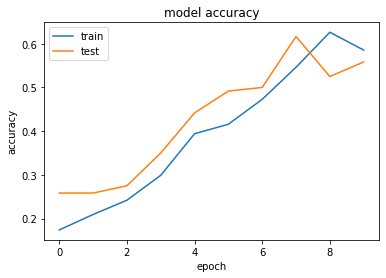

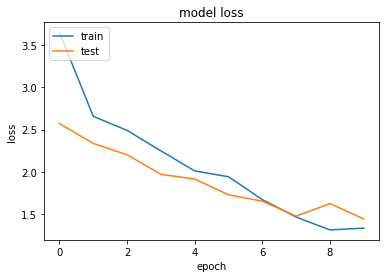

22/22 [==============================] - 18s 817ms/step
Test evaluation:
22/22 [==============================] - 17s 762ms/step - loss: 1.5497 - accuracy: 0.5140
[1.5496926307678223, 0.514018714427948]
% of correct brand in the first 3 positions:
76
0.35514018691588783
None


In [179]:
executeModelData(True, False, False, False, 10, shoes_train2, shoes_test2, shoes_val2, df_shoe_brand2,num_classes2)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
74/74 [==============================] - 138s 2s/step - loss: 3.0475 - accuracy: 0.1807 - val_loss: 2.4951 - val_accuracy: 0.2583
Epoch 2/10
74/74 [==============================] - 104s 1s/step - loss: 2.6233 - accuracy: 0.2160 - val_loss: 2.2439 - val_accuracy: 0.2917
Epoch 3/10
74/74 [==============================] - 105s 1s/step - loss: 2.1657 - accuracy: 0.3234 - val_loss: 1.6817 - val_accuracy: 0.4333
Epoch 4/10
74/74 [==============================] - 113s 2s/step - loss: 1.5499 - accuracy: 0.5014 - val_loss: 1.4435 - val_accuracy: 0.5500
Epoch 5/10
74/74 [==============================] - 95s 1s/step - loss: 1.2113 - accuracy: 0.6236 - val_loss: 1.2359 - val_accuracy: 0.6250
Epoch 6/10
74/74 [==============================] - 109s 1s/step - loss: 0.9208 - accuracy: 0.6875 - val_loss: 1.2579 - val_accuracy: 0.6000
Epoch 7/10
74/74 [==============================] - 115s 2s/step

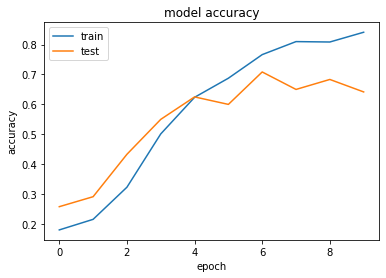

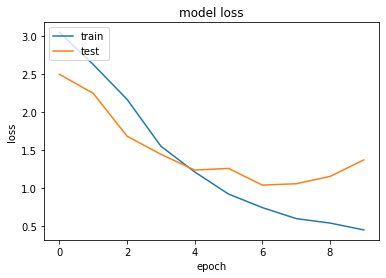

22/22 [==============================] - 7s 322ms/step
Test evaluation:
22/22 [==============================] - 8s 367ms/step - loss: 1.0555 - accuracy: 0.6822
[1.0555064678192139, 0.6822429895401001]
% of correct brand in the first 3 positions:
194
0.9065420560747663
None


In [180]:
executeModelData(False, True, True, True, 10, shoes_train2, shoes_test2, shoes_val2, df_shoe_brand2,num_classes2)

In [181]:
num_classes1, df_shoe_brand1,shoes_train1, shoes_test1, shoes_val1 = returnDataByMinSample(1)

Brands with at least 1 samples: 59
Brands with only 1 register: 0
                     X         y factor_brand
0     021_05_R_03.jpeg  Champion          0.0
1     005_10_R_05.jpeg    Cooeli          1.0
2     026_06_R_01.jpeg      Keen          2.0
3     009_08_R_05.jpeg     Asics          3.0
4     020_04_R_04.jpeg      Soma          4.0
...                ...       ...          ...
1495  017_03_R_01.jpeg      Ofem         45.0
1496  018_04_R_02.jpeg    Sperry         12.0
1497  012_05_R_03.jpeg  Namuhana         42.0
1498  009_12_L_03.jpeg     Sugar         56.0
1499  025_03_L_04.jpeg      Nike         15.0

[1470 rows x 3 columns]


 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
102/102 [==============================] - 170s 2s/step - loss: 3.8201 - accuracy: 0.1098 - val_loss: 3.6112 - val_accuracy: 0.2000
Epoch 2/10
102/102 [==============================] - 141s 1s/step - loss: 3.7033 - accuracy: 0.1355 - val_loss: 3.4105 - val_accuracy: 0.2000
Epoch 3/10
102/102 [==============================] - 141s 1s/step - loss: 3.6422 - accuracy: 0.1474 - val_loss: 3.4866 - val_accuracy: 0.2000
Epoch 4/10
102/102 [==============================] - 139s 1s/step - loss: 3.6245 - accuracy: 0.1543 - val_loss: 3.5616 - val_accuracy: 0.2000
Epoch 5/10
102/102 [==============================] - 140s 1s/step - loss: 3.6134 - accuracy: 0.1464 - val_loss: 3.3779 - val_accuracy: 0.2000
Epoch 6/10
102/102 [==============================] - 137s 1s/step - loss: 3.6178 - accuracy: 0.1543 - val_loss: 3.3736 - val_accuracy: 0.2000
Epoch 7/10
102/102 [============================

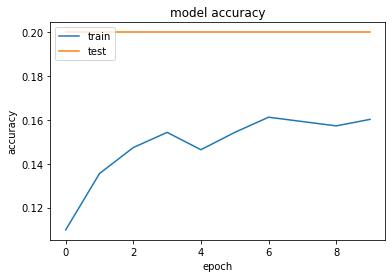

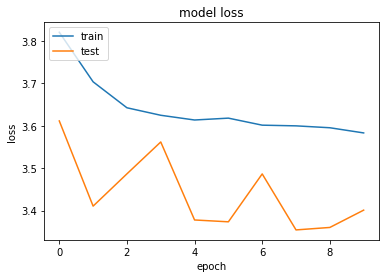

30/30 [==============================] - 11s 348ms/step
Test evaluation:
30/30 [==============================] - 10s 335ms/step - loss: 3.5422 - accuracy: 0.1497
[3.5422205924987793, 0.14965985715389252]
% of correct brand in the first 3 positions:
95
0.3231292517006803
None


In [182]:
executeModelData(False, False, False, False, 10, shoes_train1, shoes_test1, shoes_val1, df_shoe_brand1,num_classes1)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
102/102 [==============================] - 171s 2s/step - loss: 4.5740 - accuracy: 0.1276 - val_loss: 3.5622 - val_accuracy: 0.2000
Epoch 2/10
102/102 [==============================] - 165s 2s/step - loss: 3.6247 - accuracy: 0.1474 - val_loss: 3.3746 - val_accuracy: 0.2000
Epoch 3/10
102/102 [==============================] - 166s 2s/step - loss: 3.4069 - accuracy: 0.1711 - val_loss: 3.1012 - val_accuracy: 0.2424
Epoch 4/10
102/102 [==============================] - 167s 2s/step - loss: 3.2422 - accuracy: 0.2077 - val_loss: 2.8879 - val_accuracy: 0.2667
Epoch 5/10
102/102 [==============================] - 169s 2s/step - loss: 2.9931 - accuracy: 0.2265 - val_loss: 2.8020 - val_accuracy: 0.2909
Epoch 6/10
102/102 [==============================] - 187s 2s/step - loss: 2.7949 - accuracy: 0.2710 - val_loss: 2.5833 - val_accuracy: 0.2970
Epoch 7/10
102/102 [=============================

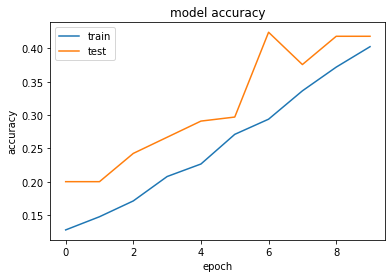

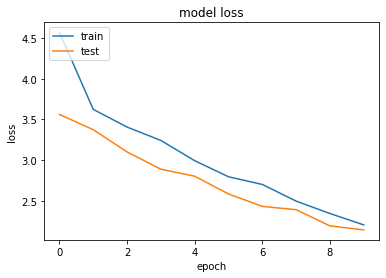

30/30 [==============================] - 23s 768ms/step
Test evaluation:
30/30 [==============================] - 18s 580ms/step - loss: 2.2956 - accuracy: 0.3980
[2.295586109161377, 0.3979591727256775]
% of correct brand in the first 3 positions:
71
0.24149659863945577
None


In [183]:
executeModelData(True, False, False, False, 10, shoes_train1, shoes_test1, shoes_val1, df_shoe_brand1,num_classes1)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
102/102 [==============================] - 165s 2s/step - loss: 14.7225 - accuracy: 0.0791 - val_loss: 15.1412 - val_accuracy: 0.0606
Epoch 2/10
102/102 [==============================] - 153s 1s/step - loss: 14.7630 - accuracy: 0.0841 - val_loss: 15.1412 - val_accuracy: 0.0606
Epoch 3/10
102/102 [==============================] - 158s 2s/step - loss: 14.7630 - accuracy: 0.0841 - val_loss: 15.1412 - val_accuracy: 0.0606
Epoch 4/10
102/102 [==============================] - 149s 1s/step - loss: 14.7632 - accuracy: 0.0841 - val_loss: 15.1412 - val_accuracy: 0.0606
Epoch 5/10
102/102 [==============================] - 164s 2s/step - loss: 14.7630 - accuracy: 0.0841 - val_loss: 15.1412 - val_accuracy: 0.0606
Epoch 6/10
102/102 [==============================] - 137s 1s/step - loss: 14.7630 - accuracy: 0.0841 - val_loss: 15.1412 - val_accuracy: 0.0606
Epoch 7/10
102/102 [===================

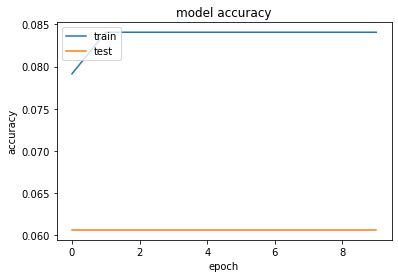

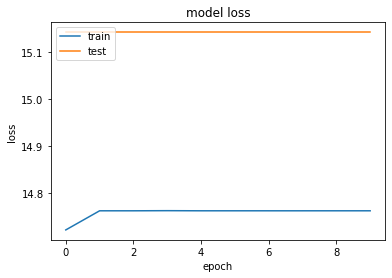

30/30 [==============================] - 7s 230ms/step
Test evaluation:
30/30 [==============================] - 9s 306ms/step - loss: 14.7475 - accuracy: 0.0850
[14.747515678405762, 0.08503401279449463]
% of correct brand in the first 3 positions:
39
0.1326530612244898
None


In [184]:
executeModelData(False, True, True, True, 10, shoes_train1, shoes_test1, shoes_val1, df_shoe_brand1,num_classes1)

In [185]:
num_classes10, df_shoe_brand10,shoes_train10, shoes_test10, shoes_val10 = returnDataByMinSample(10)

Brands with at least 10 samples: 3
Brands with only 1 register: 56
                     X       y factor_brand
3     009_08_R_05.jpeg   Asics          0.0
13    025_05_R_01.jpeg   Asics          0.0
17    011_03_L_04.jpeg  Adidas          1.0
18    021_06_R_01.jpeg    Nike          2.0
20    025_01_R_04.jpeg    Nike          2.0
...                ...     ...          ...
1484  020_19_L_05.jpeg  Adidas          1.0
1485  019_02_R_02.jpeg  Adidas          1.0
1488  027_01_L_03.jpeg    Nike          2.0
1493  011_01_R_04.jpeg  Adidas          1.0
1499  025_03_L_04.jpeg    Nike          2.0

[490 rows x 3 columns]


 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
34/34 [==============================] - 57s 2s/step - loss: 1.1230 - accuracy: 0.4718 - val_loss: 1.0487 - val_accuracy: 0.5091
Epoch 2/10
34/34 [==============================] - 45s 1s/step - loss: 1.0612 - accuracy: 0.4837 - val_loss: 1.0344 - val_accuracy: 0.5091
Epoch 3/10
34/34 [==============================] - 45s 1s/step - loss: 1.0652 - accuracy: 0.4837 - val_loss: 1.0384 - val_accuracy: 0.5091
Epoch 4/10
34/34 [==============================] - 46s 1s/step - loss: 1.0677 - accuracy: 0.4837 - val_loss: 1.0596 - val_accuracy: 0.5091
Epoch 5/10
34/34 [==============================] - 46s 1s/step - loss: 1.0607 - accuracy: 0.4837 - val_loss: 1.0525 - val_accuracy: 0.5091
Epoch 6/10
34/34 [==============================] - 47s 1s/step - loss: 1.0640 - accuracy: 0.4837 - val_loss: 1.0343 - val_accuracy: 0.5091
Epoch 7/10
34/34 [==============================] - 50s 1s/step - 

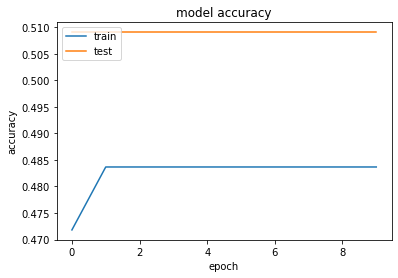

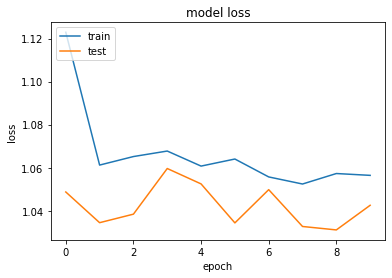

10/10 [==============================] - 4s 373ms/step
Test evaluation:
10/10 [==============================] - 4s 338ms/step - loss: 1.0473 - accuracy: 0.5000
[1.0473392009735107, 0.5]
% of correct brand in the first 3 positions:
98
1.0
None


In [186]:
executeModelData(False, False, False, False, 10, shoes_train10, shoes_test10, shoes_val10, df_shoe_brand10,num_classes10)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
34/34 [==============================] - 65s 2s/step - loss: 3.7199 - accuracy: 0.4837 - val_loss: 1.0035 - val_accuracy: 0.5091
Epoch 2/10
34/34 [==============================] - 58s 2s/step - loss: 0.9918 - accuracy: 0.4866 - val_loss: 0.9938 - val_accuracy: 0.5091
Epoch 3/10
34/34 [==============================] - 54s 2s/step - loss: 0.9338 - accuracy: 0.4926 - val_loss: 0.9598 - val_accuracy: 0.6000
Epoch 4/10
34/34 [==============================] - 57s 2s/step - loss: 0.9508 - accuracy: 0.5994 - val_loss: 0.9478 - val_accuracy: 0.5818
Epoch 5/10
34/34 [==============================] - 61s 2s/step - loss: 0.8313 - accuracy: 0.6320 - val_loss: 0.8870 - val_accuracy: 0.6182
Epoch 6/10
34/34 [==============================] - 60s 2s/step - loss: 0.8005 - accuracy: 0.6499 - val_loss: 0.9290 - val_accuracy: 0.5091
Epoch 7/10
34/34 [==============================] - 59s 2s/step - l

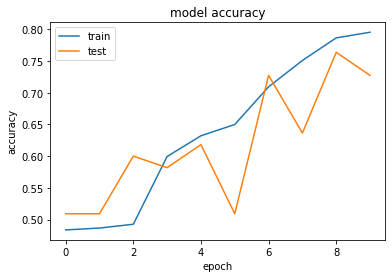

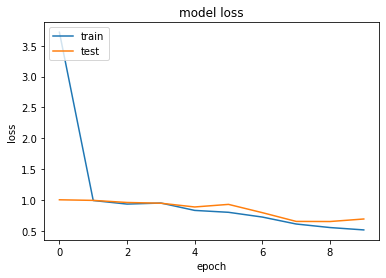

10/10 [==============================] - 9s 841ms/step
Test evaluation:
10/10 [==============================] - 9s 821ms/step - loss: 0.6256 - accuracy: 0.7755
[0.6255520582199097, 0.7755101919174194]
% of correct brand in the first 3 positions:
98
1.0
None


In [187]:
executeModelData(True, False, False, False, 10, shoes_train10, shoes_test10, shoes_val10, df_shoe_brand10,num_classes10)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
34/34 [==============================] - 48s 1s/step - loss: 2.3838 - accuracy: 0.4570 - val_loss: 1.0641 - val_accuracy: 0.5091
Epoch 2/10
34/34 [==============================] - 46s 1s/step - loss: 0.9802 - accuracy: 0.5638 - val_loss: 0.7955 - val_accuracy: 0.6727
Epoch 3/10
34/34 [==============================] - 59s 2s/step - loss: 0.6527 - accuracy: 0.7418 - val_loss: 0.9108 - val_accuracy: 0.6182
Epoch 4/10
34/34 [==============================] - 70s 2s/step - loss: 0.4349 - accuracy: 0.8309 - val_loss: 0.6179 - val_accuracy: 0.7091
Epoch 5/10
34/34 [==============================] - 56s 2s/step - loss: 0.3215 - accuracy: 0.8932 - val_loss: 0.5995 - val_accuracy: 0.7091
Epoch 6/10
34/34 [==============================] - 48s 1s/step - loss: 0.1796 - accuracy: 0.9436 - val_loss: 0.5640 - val_accuracy: 0.8182
Epoch 7/10
34/34 [==============================] - 42s 1s/step - los

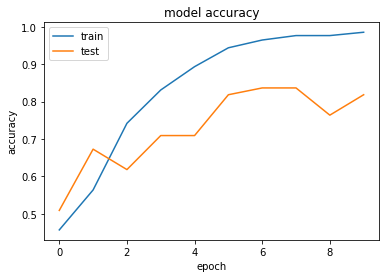

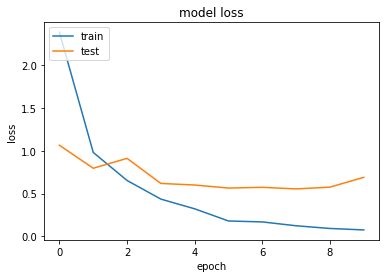

10/10 [==============================] - 4s 364ms/step
Test evaluation:
10/10 [==============================] - 4s 386ms/step - loss: 0.5316 - accuracy: 0.8265
[0.5316194295883179, 0.8265306353569031]
% of correct brand in the first 3 positions:
98
1.0
None


In [188]:
executeModelData(False, True, True, True, 10, shoes_train10, shoes_test10, shoes_val10, df_shoe_brand10,num_classes10)

In [ ]:
num_classes5None, df_shoe_brand5None,shoes_train5None, shoes_test5None, shoes_val5None = returnDataByMinSample(5,False)

In [ ]:
executeModelData(False, False, False, False, 10, shoes_train5None, shoes_test5None, shoes_val5None, df_shoe_brand5None,num_classes5None)

In [ ]:
executeModelData(True, False, False, False, 10, shoes_train5None, shoes_test5None, shoes_val5None, df_shoe_brand5None,num_classes5None)

In [ ]:
executeModelData(False, True, True, True, 10, shoes_train5None, shoes_test5None, shoes_val5None, df_shoe_brand5None,num_classes5None)

### Experimentos con diferentes tamaños de imagen

Primero se procede a descomprimir las imágenes con su tamaño original de 2083x4563 y guardarlas en la carpeta images_full.

*Este proceso puede tardar, ya que estan en formato .tiff y hay que convertiralas una a una a .jpeg

In [70]:
unzipImages('images_full')
get_images_full_to_jpeg('images_full')

Nº files: 1500


['008_02_L_05.jpeg',
 '003_02_L_03.jpeg',
 '004_01_L_01.jpeg',
 '006_04_L_01.jpeg',
 '009_03_L_02.jpeg',
 '005_07_L_01.jpeg',
 '007_02_L_01.jpeg',
 '012_08_R_01.jpeg',
 '026_11_L_05.jpeg',
 '008_05_L_02.jpeg',
 '020_08_L_04.jpeg',
 '009_04_L_05.jpeg',
 '005_03_L_04.jpeg',
 '007_06_L_04.jpeg',
 '020_17_L_05.jpeg',
 '003_01_L_01.jpeg',
 '002_07_L_01.jpeg',
 '007_01_L_03.jpeg',
 '005_04_L_03.jpeg',
 '020_10_L_02.jpeg',
 '004_05_L_04.jpeg',
 '026_09_L_03.jpeg',
 '020_04_L_02.jpeg',
 '017_02_R_05.jpeg',
 '022_01_L_02.jpeg',
 '005_10_L_03.jpeg',
 '009_08_L_03.jpeg',
 '021_05_L_05.jpeg',
 '018_02_R_01.jpeg',
 '017_05_R_02.jpeg',
 '020_03_L_05.jpeg',
 '014_01_R_05.jpeg',
 '020_18_L_01.jpeg',
 '021_02_L_02.jpeg',
 '005_08_L_05.jpeg',
 '025_01_L_02.jpeg',
 '010_02_R_05.jpeg',
 '009_10_L_05.jpeg',
 '012_07_R_05.jpeg',
 '026_05_L_05.jpeg',
 '011_03_R_02.jpeg',
 '025_06_L_05.jpeg',
 '018_01_R_03.jpeg',
 '011_04_R_05.jpeg',
 '026_02_L_02.jpeg',
 '013_01_R_05.jpeg',
 '019_01_L_05.jpeg',
 '011_05_L_04

In [ ]:
crop_jpeg(160, 'images_full')

In [ ]:
def executeModelWithShape(aumentation, gray, binary, crop, epoch, w, h):
   
    modelTest = createModelTestCustomShape(not gray, w,h)
    
    modelTest.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    #Configurar el preprocesado que se hará en las imágenes desntro del Generator.
    trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    print(" ")
    print('Training model with aumentation:'+str(aumentation)+', gray:'+str(gray)+', binary:'+str(binary)+', crop:'+str(crop)+' and epochs = '+str(epoch))
    trainHistory = modelTest.fit(trainGenerator,validation_data=valGenerator, epochs=epoch)
    
    plot_history(trainHistory)
    
    predicted_y = modelTest.predict(testGenerator)
    print("Test evaluation:")
    print(modelTest.evaluate(testGenerator))
    print("% of correct brand in the first 3 positions:")
    print(checkAccuracyFirstPositions(predicted_y, shoes_test,3))
    
    

In [ ]:
executeModelWithShape(False, False, False, False, 10, 1763,4243) #original - 320 (marco)

## Uso de autokeras
La librería autokeras se encarga de buscar la combinación de Layers del modelo que puede obtener mejor resultado.


In [ ]:
!pip install autokeras

In [2]:
import autokeras as ak

In [34]:
#https://autokeras.com/image_classifier/
#https://medium.com/analytics-vidhya/how-to-use-autokeras-to-build-image-classification-models-using-one-line-of-code-c35b0c36e66e

X = np.empty([280,832], dtype=int)

X = np.array([io.imread("images/"+p) for p in shoes_train.X.values])

print(X.shape)


(529, 832, 280, 3)


In [33]:
clf = ak.ImageClassifier( num_classes=num_classes, max_trials=1,loss = 'binary_crossentropy',
     objective='val_accuracy')

autohistory = clf.fit(X, shoes_train['y'],epochs=10, validation_split = 0.2)


INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
17/17 [==============================] - 232s 13s/step - loss: 39.9158 - accuracy: 0.2042
Epoch 2/10
17/17 [==============================] - 275s 16s/step - loss: 1.2142 - accuracy: 0.6503
Epoch 3/10
17/17 [==============================] - 265s 16s/step - loss: 0.1399 - accuracy: 0.9868
Epoch 4/10
17/17 [==============================] - 248s 14s/step - loss: 0.0034 - accuracy: 1.0000
Epoch 5/10
17/17 [==============================] - 249s 15s/step - loss: 4.1644e-04 - accuracy: 1.0000
Epoch 6/10
17/17 [==============================] - 227s 13s/step - loss: 2.3430e-04 - accuracy: 1.0000
Epoch 7/10
17/17 [==============================] - 241s 14s/step - loss: 2.0629e-04

INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 832, 280, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 832, 280, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 832, 280, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 830, 278, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 828, 276, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 414, 138, 64)     0     

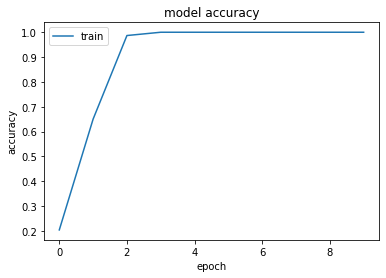

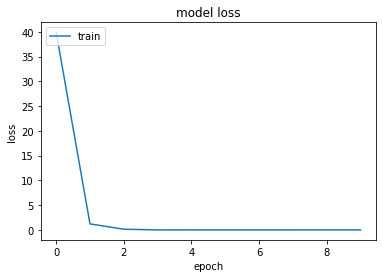

In [42]:
model = clf.export_model()

# Capas que ha creado como mejor modelo:
model.summary()

plot_history_2(autohistory)

In [43]:
# Predicción con el modelo escogido por autokeras.
test = np.empty([280,832], dtype=int)

test = np.array([io.imread("images/"+p) for p in shoes_test.X.values])

predicted_auto_y = clf.predict(test)


5/5 [==============================] - 11s 2s/step


In [44]:

# Evaluate the best model with testing data.
print(clf.evaluate(test, shoes_test['y']))

5/5 [==============================] - 12s 2s/step - loss: 1.3084 - accuracy: 0.5714
[1.3083676099777222, 0.5714285969734192]


['Asics']


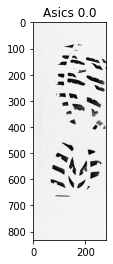

In [45]:
showResult(predicted_auto_y[0],shoes_test.iloc[0], False)

In [46]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(confusion_matrix(shoes_test['y'],predicted_auto_y))


[[12  1  0  9  0  0  0]
 [ 2 15  0 14  0  0  0]
 [ 1  1  9  5  0  0  0]
 [ 4  2  0 42  0  0  0]
 [ 0  0  0  6  1  0  0]
 [ 1  0  0 13  0  1  0]
 [ 3  0  0  4  0  0  8]]


In [ ]:
#experimento con epoch=25
clf25 = ak.ImageClassifier( num_classes=num_classes, max_trials=1,loss = 'binary_crossentropy',
     objective='val_accuracy')
autohistory25 = clf25.fit(X, shoes_train['y'],epochs=25, validation_split = 0.2)


In [ ]:
test = np.empty([280,832], dtype=int)

test = np.array([io.imread("images/"+p) for p in shoes_test.X.values])

predicted_auto_y = clf25.predict(test)


In [ ]:
# Evaluate the best model with testing data.
print(clf25.evaluate(test, shoes_test['y']))


[Falta comentario]
¿Esto implica sobreentrenamiento?

## Uso de modelo pre-entrenado ImageNet

VGG16 preentrenado (sin desbloquear capas):

In [97]:
test = np.empty([280,832], dtype=int)

test = np.array([io.imread("images/"+p) for p in shoes_test.X.values])

In [ ]:
#https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29

from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, BatchNormalization
import ssl
#se usa para evitar el error SSL que lanza VGG16
ssl._create_default_https_context = ssl._create_unverified_context

#vgg16 por defecto usa ImageNet:
#modelPre = models.Sequential()
#modelPre.add(VGG16(include_top=False, input_shape=(832, 280, 3), 
                   weights="imagenet", classes = num_classes, classifier_activation="softmax"))
#modelPre.add(Flatten())
#modelPre.add(Dense(512, activation='relu'))
#modelPre.add(BatchNormalization())
#modelPre.add(Dropout(0.5))
#modelPre.add(Dense(num_classes))



inp = Input(shape= (320,872, 3))
out = VGG16(weights='imagenet')(inp)
modelPre = Model(inputs=inp, outputs=out)

modelPre.summary()

In [78]:
import tensorflow as tf
modelPre.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
trainGeneratorPre=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
testGeneratorPre=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
valGeneratorPre=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/",False, False, False)


In [ ]:
preHistory = modelPre.fit(trainGeneratorPre,validation_data=valGeneratorPre, epochs=10)

In [ ]:
plot_history(preHistory)

In [ ]:
print(modelPre.evaluate(testGeneratorPre))

In [ ]:
pre_predicted_y = modelPre.predict(test)

In [393]:
checkAccuracyFirstPositions(pre_predicted_y, shoes_test,3)

65
0.42207792207792205


### VGG16 desbloqueando las primeras capas para que entrene con el conjunto de datos del proyecto.

In [426]:
#pruebas
vgg_model = VGG16(include_top=False, input_shape=(832, 280, 3))
for layer in vgg_model.layers[-4:]:
    layer.trainable = True
    
modelPre2 = models.Sequential()
modelPre2.add(vgg_model)
modelPre2.add(Flatten())
modelPre2.add(Dense(512, activation='relu'))
modelPre2.add(BatchNormalization())
modelPre2.add(Dropout(0.5))
modelPre2.add(Dense(num_classes))
modelPre2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 26, 8, 512)        14714688  
                                                                 
 flatten_54 (Flatten)        (None, 106496)            0         
                                                                 
 dense_63 (Dense)            (None, 512)               54526464  
                                                                 
 batch_normalization_264 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_64 (Dense)            (None, 7)                 3591      
                                                     

In [ ]:
modelPre2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
trainGeneratorPre2=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,False, "images/", False)
testGeneratorPre2=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/", False)
valGeneratorPre2=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/",False)

preHistory2 = modelPre2.fit(trainGeneratorPre2,validation_data=valGeneratorPre2, epochs=10)

In [ ]:
plot_history(preHistory2)

In [ ]:
pre_predicted_y2 = modelPre2.predict(test)

In [ ]:
checkAccuracyFirstPositions(pre_predicted_y2, shoes_test,3)

### RestNet50

ResNet50 + capas

In [139]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50


modelPre3 = models.Sequential()
modelPre3.add(ResNet50(include_top=False, input_shape=(832, 280, 3), 
                   weights="imagenet", classes = num_classes, classifier_activation="softmax"))
modelPre3.add(Flatten())
modelPre3.add(Dense(512, activation='relu'))
modelPre3.add(BatchNormalization())
modelPre3.add(Dropout(0.5))
modelPre3.add(Dense(num_classes, activation='softmax'))
modelPre3.add(Flatten())



modelPre3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 26, 9, 2048)       23587712  
                                                                 
 flatten_11 (Flatten)        (None, 479232)            0         
                                                                 
 dense_21 (Dense)            (None, 512)               245367296 
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 7)                 3591      
                                                     

In [140]:

modelPre3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [141]:
trainGeneratorPre3=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
testGeneratorPre3=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
valGeneratorPre3=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/",False, False, False)



In [143]:
preHistory3 = modelPre3.fit(trainGeneratorPre3,validation_data=valGeneratorPre3, epochs=10)

53/53 [==============================] - 1821s 34s/step - loss: 1.2982 - accuracy: 0.6144 - val_loss: 11.6717 - val_accuracy: 0.2759


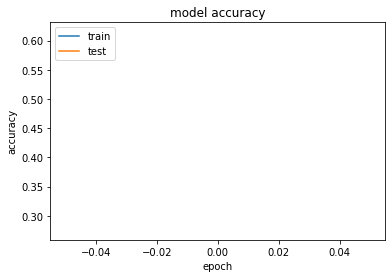

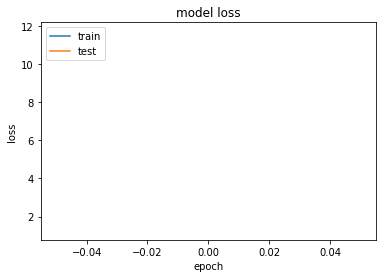

In [144]:
plot_history(preHistory3)

In [145]:
print(modelPre3.evaluate(testGeneratorPre3))

16/16 [==============================] - 66s 4s/step - loss: 11.0943 - accuracy: 0.3117
[11.094273567199707, 0.31168830394744873]


In [146]:
test = np.empty([280,832], dtype=int)

test = np.array([io.imread("images/"+p) for p in shoes_test.X.values])
pre_predicted_y3 = modelPre3.predict(test)

5/5 [==============================] - 68s 12s/step


[0. 0. 0. 0. 1. 0. 0.]
[4 0 1 2 3 5 6]


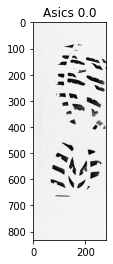

In [147]:
showResult(pre_predicted_y3[0],shoes_test.iloc[0], True)

In [152]:
checkAccuracyFirstPositions(pre_predicted_y3, shoes_test,3)

91
0.5909090909090909


In [ ]:
modelPre4 = models.Sequential()
modelPre4.add(ResNet50(include_top=False, input_shape=(832, 280, 3), 
                   weights="imagenet", classes = num_classes, classifier_activation="softmax"))
modelPre4.add(Flatten())

modelPre4.summary()

modelPre4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

trainGeneratorPre4=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
testGeneratorPre4=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
valGeneratorPre4=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/",False, False, False)



In [ ]:
preHistory4 = modelPre4.fit(trainGeneratorPre4,validation_data=valGeneratorPre4, epochs=10)

In [ ]:
print(modelPre4.evaluate(testGeneratorPre4))

In [ ]:
test = np.empty([280,832], dtype=int)

test = np.array([io.imread("images/"+p) for p in shoes_test.X.values])
pre_predicted_y4 = modelPre4.predict(test)



In [ ]:
checkAccuracyFirstPositions(pre_predicted_y4, shoes_test,1)

In [ ]:
checkAccuracyFirstPositions(pre_predicted_y4, shoes_test,3)

## Análisis de resultados

https://pypi.org/project/tabulate/
